Copying codes from William's notebook to do some exploration

In [2]:
import pyccl as ccl
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pickle
from scipy.integrate import quad, dblquad
from scipy import interpolate
import time


#Set up a cosmology


cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.677, A_s=2.1e-9, n_s=0.9675,transfer_function='boltzmann_camb')
def ra_cosmo(z):
    return(ccl.comoving_angular_distance(cosmo, 1/(1+z)))

def D_cosmo(z):
    return ccl.growth_factor(cosmo,1/(1+z))



In [86]:
cosmo.linear_matter_power

<bound method linear_matter_power of <pyccl.cosmology.Cosmology>
	A_s     = 2.1e-09
	Neff    = 3.044
	Omega_b = 0.045
	Omega_c = 0.27
	h       = 0.677
	n_s     = 0.9675
	extra_parameters =
	HASH_ACCURACY_PARAMS = 0x94913621e7ea5352>

In [3]:
def chi(z):
    return(ccl.comoving_radial_distance(cosmo, 1/(1+z)))

def z_chi(chi):
    return 1/ccl.scale_factor_of_chi(cosmo, chi)-1

def r_3d_rp(rp,z1,z2):
    return ((chi(z1)-chi(z2))**2+(rp)**2)**0.5

def xi_m(r,z):
    return ccl.correlations.correlation_3d(cosmo,a=1/(1+z),r=r,p_of_k_a='delta_matter:delta_matter')

In [4]:
Zlist=[2.+k/200 for k in range(200)]
R3d=np.logspace(-1.,2.5,num=40, endpoint=True, base=10.0, dtype=None, axis=0)

Below only need to run once

In [5]:
Xi_3d=np.loadtxt('xi3d_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d=np.transpose(Xi_3d)

XI_interp=[]
for iz in range(len(Zlist)):
    XI_interp.append(interpolate.interp1d(R3d, Xi_3d[iz]))

print(np.shape(R3d), ' points for rp and ',np.shape(Zlist), ' for z')


print('minimal distance', round(R3d[0],4), 'Mpc and maximal ', round(R3d[-1],2),'Mpc')
print('minimal redshift', Zlist[0], ' and maximal ', round(Zlist[-1],2))

(40,)  points for rp and  (200,)  for z
minimal distance 0.1 Mpc and maximal  316.23 Mpc
minimal redshift 2.0  and maximal  3.0


In [6]:
# find the best indices with dichotomy

def find_r(x):
    arr=R3d
    ind_max=len(arr)
    left, right = 0, ind_max - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    if left==ind_max:
        return ind_max-1
    return left

def find_z(x):
    arr=Zlist
    ind_max=len(arr)
    left, right = 0, ind_max - 1
    while left <= right:
        mid = (left + right) // 2
        if arr[mid] < x:
            left = mid + 1
        else:
            right = mid - 1
    if left==ind_max:
        return ind_max-1
    return left

In [7]:
def wnotLimber(zmean,Delta_z, rp): # Here we assume tophat n(z), much faster than the following function

    zmin=-Delta_z/2
    zmax=+Delta_z/2
    
    def integrate_z1(z1):
        index_z=find_z(zmean+z1) # find the best z-index for xi
        #xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
        xi_r=XI_interp[index_z]
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

def wnotLimber_n(z_array,nz1,nz2, rp): 
    '''
    implementation of the 2pt correlation w(theta) between two samples (1 and 2), without approximation (linear bias)!?
    ---
    z_array and nz1, nz2, are the 3 arrays describing the !!normalised!! redshift distributions of the two samples 
   rp the comoving perp distance in Mpc
    ----
    Of course, possibly nz1=nz2.
    If nz1 and nz2 are functions of the Hubble redshift, then this calculation **includes RSD**.
    z_array can cover a large redshift range, even if nz1 is non-zero over a very small range.
    What should be avoided is to have a large z-range, with a nz non-zero but very very small over the full range,
    because it will be very hard to evaluate the integrals
    '''

    n1=interpolate.interp1d(z_array,nz1)
    n2=interpolate.interp1d(z_array,nz2)

    # find the first iz such that nz1!=0:
    iz_min=0
    while nz1[iz_min+1]==0:
        iz_min+=1
    #same but in the other direction
    iz_max=len(z_array)-1
    while nz1[iz_max-1]==0:
        iz_max+=-1

    #range of the integral. 
    zmin=z_array[iz_min] 
    zmax=z_array[iz_max]
    
    def integrate_z1(z1):
        index_z=find_z(z1) # find the best z-index for xi
        xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
        #xi_r=XI_interp[index_z]
        def integrate_z2(z2):
            r=r_3d_rp(rp,z1,z2) # what is the r3d given our redshifts
            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return n1(z1)*n2(z2)*xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]


def wnotLimber_theta(zmean,Delta_z, theta_arcmin): #again, top hat n(z).
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean)
    

    zmin=-Delta_z/2
    zmax=+Delta_z/2
    
    def integrate_z1(z1):
        index_z=find_z(zmean+z1)
        #xi_r=interpolate.interp1d(R3d, Xi_3d[index_z])
        xi_r=XI_interp[index_z]
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2)
            
            if r<0.11:
                return 0
            if r>300:
                return 0
            return xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]


def wnotLimber_theta_n(z_array,nz1,nz2, theta_arcmin): 
    '''
    implementation of the 2pt correlation w(theta) between two samples (1 and 2), without approximation (linear bias)!?
    ---
    z_array and nz1, nz2, are the 3 arrays describing the !!normalised!! redshift distributions of the two samples 
    theta_arcmin the angular separation in arcmin.
    ----
    Of course, possibly nz1=nz2.
    If nz1 and nz2 are functions of the Hubble redshift, then this calculation **includes RSD**.
    z_array can cover a large redshift range, even if nz1 is non-zero over a very small range.
    What should be avoided is to have a large z-range, with a nz non-zero but very very small over the full range,
    because it will be very hard to evaluate the integrals.
    '''
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    
    n1=interpolate.interp1d(z_array,nz1)
    n2=interpolate.interp1d(z_array,nz2)

    # find the first iz such that nz1[iz+1]!=0:
    iz_min=0
    while nz1[iz_min+1]==0:
        iz_min+=1
    #same but in the other direction
    iz_max=len(z_array)-1
    while nz1[iz_max-1]==0:
        iz_max+=-1

    #range of the integral. 
    zmin=z_array[iz_min] 
    zmax=z_array[iz_max]

    #print('range ',zmin,zmax)
    def integrate_z1(z1):
        index_z=find_z(z1) # find the best z-index for xi
        xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
        rp=theta_rad*ra_cosmo(z1)
        def integrate_z2(z2):
            r=r_3d_rp(rp,z1,z2) # what is the r3d given our redshifts

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return n1(z1)*n2(z2)*xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
        
    return quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]



In [8]:
def wLimber(zmean,Delta_z, rp): 

    zmin=-Delta_z/2
    zmax=+Delta_z/2

    index_z=find_z(zmean)
    xi_r=interpolate.interp1d(R3d, Xi_3d[index_z])
    
    def integrate_z(z):
        r=r_3d_rp(rp,zmean,zmean+z)
        if r>300:
            return 0
        if r<0.11:
            return 0
        return xi_r(r)

    return 1/Delta_z*quad(integrate_z, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    
def wLimber_theta(zmean,Delta_z, theta_arcmin): #return eta+ for a bin centred in z with width Delta_z
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg


    zmin=-Delta_z/2
    zmax=+Delta_z/2

    index_z=find_z(zmean)
    xi_r=interpolate.interp1d(R3d, Xi_3d[index_z])
    
    def integrate_z(z):
        r=r_3d_rp(rp,zmean,zmean+z)
        if r>300:
            return 0
        if r<0.11:
            return 0
        return xi_r(r)

    return 1/Delta_z*quad(integrate_z, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    

In [9]:
def wnotLimber_theta_n(z_array,nz1,nz2, theta_arcmin): 
    '''
    implementation of the 2pt correlation w(theta) between two samples (1 and 2), without approximation (linear bias)!?
    ---
    z_array and nz1, nz2, are the 3 arrays describing the !!normalised!! redshift distributions of the two samples 
    theta_arcmin the angular separation in arcmin.
    ----
    Of course, possibly nz1=nz2.
    If nz1 and nz2 are functions of the Hubble redshift, then this calculation **includes RSD**.
    z_array can cover a large redshift range, even if nz1 is non-zero over a very small range.
    What should be avoided is to have a large z-range, with a nz non-zero but very very small over the full range,
    because it will be very hard to evaluate the integrals.
    '''
    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    
    n1=interpolate.interp1d(z_array,nz1)
    n2=interpolate.interp1d(z_array,nz2)

    # find the first iz such that nz1[iz+1]!=0:
    iz_min=0
    while nz1[iz_min+1]==0:
        iz_min+=1
    #same but in the other direction
    iz_max=len(z_array)-1
    while nz1[iz_max-1]==0:
        iz_max+=-1

    #range of the integral. 
    zmin=z_array[iz_min] 
    zmax=z_array[iz_max]

    #print('range ',zmin,zmax)
    def integrate_z1(z1):
        index_z=find_z(z1) # find the best z-index for xi
        xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
        rp=theta_rad*ra_cosmo(z1)
        def integrate_z2(z2):
            r=r_3d_rp(rp,z1,z2) # what is the r3d given our redshifts

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return n1(z1)*n2(z2)*xi_r(r)
            
        return quad(integrate_z2, zmin, zmax,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
        
    return quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

In [11]:
a=time.time()
print('w=',wnotLimber(2.5,0.1, 5))
print(round(time.time(),3)-a,' seconds')

a=time.time()
print('w=',wnotLimber(2.5,0.1, 50))
print(round(time.time(),3)-a,' seconds')

print('large scales are much faster to evaluate!')

w= 0.03703926428834724
9.673442602157593  seconds
w= 0.0019598660146792454
0.8243062496185303  seconds
large scales are much faster to evaluate!


In [12]:
rp=5
Dz=0.025
zmean=2.5
(wLimber(zmean,Dz, rp)-wnotLimber(zmean,Dz, rp))/wLimber(zmean,Dz, rp)

0.12069968127684445

# Below RSD

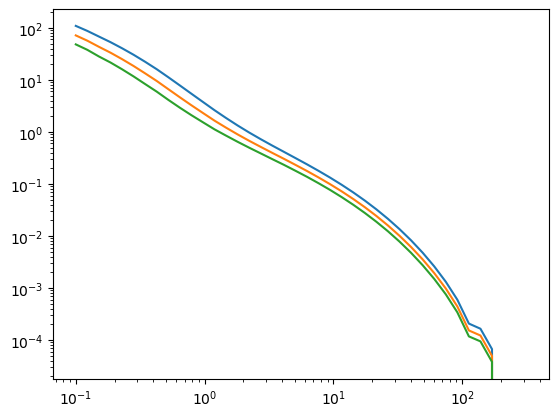

In [23]:
plt.loglog(R3d, Xi_3d[0,:])
plt.loglog(R3d, Xi_3d[100,:])
plt.loglog(R3d, Xi_3d[199,:])

In [10]:
def xi_m_bar(R, z):
    index_z=find_z(z)
    xi_r=XI_interp[index_z]
    def integrate_r3d(r):
        return r**2*xi_r(r)
    return 3/R**3*quad(integrate_r3d, 0.1, R, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


def xi_m_barbar(R, z):
    index_z=find_z(z)
    xi_r=XI_interp[index_z]
    def integrate_r3d(r):
        return r**4*xi_r(r)
    return 5/R**5*quad(integrate_r3d, 0.1, R, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

In [11]:
Xi_3d_bar=np.loadtxt('xi3d_bar_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d_bar=np.transpose(Xi_3d_bar)

XI_bar_interp=[]
for iz in range(len(Zlist)):
    XI_bar_interp.append(interpolate.interp1d(R3d, Xi_3d_bar[iz]))

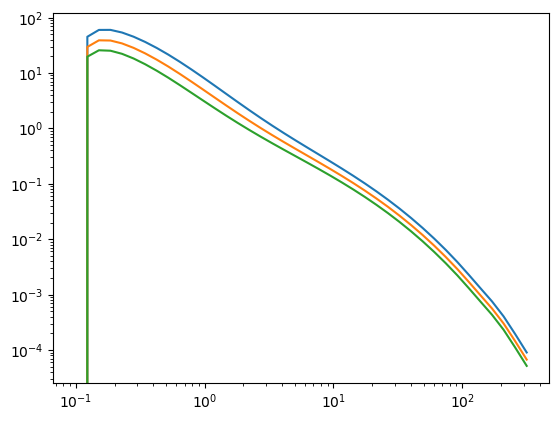

In [44]:
plt.loglog(R3d, Xi_3d_bar[0,:])
plt.loglog(R3d, Xi_3d_bar[99,:])
plt.loglog(R3d, Xi_3d_bar[199,:])

In [12]:
Xi_3d_barbar=np.loadtxt('xi3d_barbar_estimator_z2_3_logrm1_p2.5.txt',skiprows=0,unpack=True)
Xi_3d_barbar=np.transpose(Xi_3d_barbar)

XI_barbar_interp=[]
for iz in range(len(Zlist)):
    XI_barbar_interp.append(interpolate.interp1d(R3d, Xi_3d_barbar[iz]))

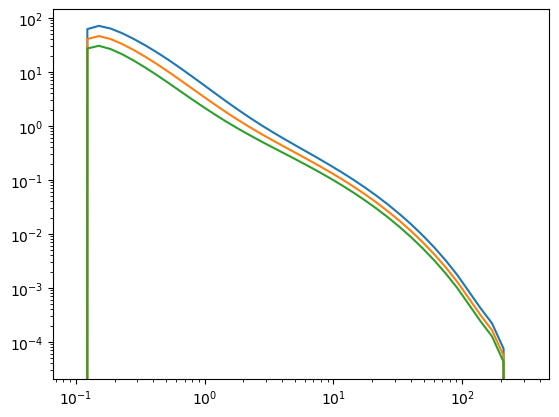

In [50]:
plt.loglog(R3d, Xi_3d_barbar[0,:])
plt.loglog(R3d, Xi_3d_barbar[99,:])
plt.loglog(R3d, Xi_3d_barbar[199,:])

!!!Note!!! First few points for xi_bar and xi_barbar cannot be trusted, because I used the pre-computed xi_r. The precise version would be using the full integral xi_m(r,z), but testing this for computing 1 single point takes about 3 - 6 min! For speed I choose to use the approximate version, which should work on large enough scales.

In [13]:
def xi_rsd(R,z,mu,beta,beta2=None):
    """Note beta is also a function of z, we will compute it later
    """
    if beta2 == None:
        beta2 = np.copy(beta)
        
    index_z=find_z(z) # find the best z-index for xi
    
    xi_r=XI_interp[index_z]
    xi_0 = (1 + 1/3.*(beta + beta2) + 1/5.*beta*beta2)*xi_r(R)

    xi_bar_r=XI_bar_interp[index_z]
    xi_2 = (2/3.*(beta + beta2) + 4/7.*beta*beta2)*(xi_r(R) - xi_bar_r(R))

    xi_barbar = XI_barbar_interp[index_z]
    xi_4 = 8/35.*beta*beta2*(xi_r(R) + 5/2.*xi_bar_r(R) - 7/2.*xi_barbar(R))
    
    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)
    P_4 = 1/8.*(35*mu**4 - 30*mu**2 + 3)

    return xi_0*P_0 + xi_2*P_2 + xi_4*P_4

In [14]:
def omega_m_z(z):
    omega_m0 = 0.315
    return omega_m0*(1+z)**3/(omega_m0*(1+z)**3 + (1-omega_m0))

In [15]:
# let's choose a z, and generate xi_rsd on a grid:
rperp = np.linspace(1, 80, 100)
rpara = np.linspace(10, 50, 100)
xx,yy = np.meshgrid(rperp,rpara,indexing='xy')
R = np.sqrt(xx**2+yy**2)
mu = yy/R
z = 2.5
# let's just assume some bias b=2.5 and a simplified model for the growth rate, f = Omega_m^0.55
b_g = 2.5
beta = omega_m_z(z)**0.55/b_g
print(beta)
res = xi_rsd(R,z,mu,beta,beta2=None)

0.3892621984717692


Text(0.5, 1.0, 'zmean=2.5, beta = 0.39')

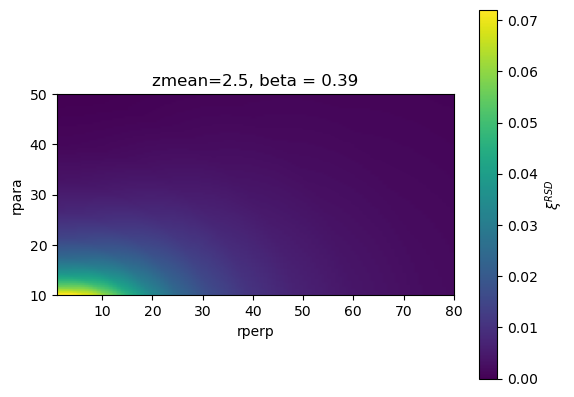

In [111]:
# make the four quadrants:
plt.imshow(res, extent=[1,80,10,50],origin="lower")
plt.colorbar(label="$\\xi^{RSD}$")
plt.xlabel("rperp")
plt.ylabel("rpara")
plt.title("zmean=2.5, beta = 0.39")

In [16]:
def mu_rsd(z1,z2,r):
    return (chi(z1)-chi(z2))/r

In [17]:
def wnotLimber_rsd(zmean, Delta_z, rp, beta, beta2=None): # Here we assume tophat n(z), much faster than the following function
    """Assume fixed beta, in principle apply beta as a function of z, need to interpolate beta curve
    """
    zmin=-Delta_z/2
    zmax=+Delta_z/2
    
    def integrate_z1(z1):
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return xi_rsd(r,zmean+z1,mu,beta,beta2=beta2)
        return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

    
def wnotLimber_rsd_theta(zmean, Delta_z, theta_arcmin, beta, beta2=None): # Here we assume tophat n(z), much faster than the following function
    """Assume fixed beta, in principle apply beta as a function of z, need to interpolate beta curve
    """
    zmin=-Delta_z/2
    zmax=+Delta_z/2

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
                
            return xi_rsd(r,zmean+z1,mu,beta,beta2=beta2)
        return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

In [18]:
def wnotLimber_rsd_theta_auto(zmean, Delta_z, theta_arcmin, beta_law, bias_law, tracer="gal"): # Here we assume tophat n(z), much faster than the following function
    """
    tracer = gal or lya.
    if gal, beta is dependent on the bias law
    if lya, just a function of z
    """
    zmin=-Delta_z/2
    zmax=+Delta_z/2

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        def integrate_z2(z2):
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
            if tracer=="gal":
                beta = beta_law(zmean+z1, bias_law)
                beta2 = beta_law(zmean+z2, bias_law)
            elif tracer == "lya":
                beta = beta_law(zmean+z1)
                beta2 = beta_law(zmean+z2)
            old_output=xi_rsd(r,zmean+z1,mu, beta = beta, beta2 = beta2)
            return old_output*bias_law(zmean+z1)*bias_law(zmean+z2)
        return quad(integrate_z2, zmin, zmax, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return 1/Delta_z**2*quad(integrate_z1,zmin,zmax,epsrel=10**(-3),epsabs=10**(-7),limit=100)[0]

In [19]:
def wnotLimber_rsd_theta_cross(zmean, Delta_z, nz_law, theta_arcmin, beta_law1, beta_law2=None,
                              bias_law1=None, bias_law2=None): # Here we assume tophat n(z), much faster than the following function
    """
    Because of the relatively broad kernel, we take into account all 
    functions varying with redshift in the integrand. This includes both 
    beta and bias.
    --Update: including bias makes it very hard to converge...
    """
    zmin2=-Delta_z/2
    zmax2=+Delta_z/2

    zmin1=1.8-zmean
    zmax1=3.0-zmean

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        # outer integral over the photometric n(z)
        def integrate_z2(z2):
            # inner integral over the top hat
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
            old_output = xi_rsd(r,zmean+z1,mu,beta_law1(zmean+z1, bias_law1),beta2=beta_law2(zmean+z2))
            return old_output*nz_law(zmean+z1)*bias_law1(zmean+z1)*bias_law2(zmean+z2)
        return 1/Delta_z*quad(integrate_z2, zmin2, zmax2, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return quad(integrate_z1,zmin1,zmax1,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

In [20]:
def wnotLimber_theta_cross(zmean, Delta_z, nz_law, theta_arcmin,
                              bias_law1=None, bias_law2=None): # Here we assume tophat n(z), much faster than the following function
    """
    Because of the relatively broad kernel, we take into account all 
    functions varying with redshift in the integrand. This includes both 
    beta and bias.
    --Update: including bias makes it very hard to converge...
    """
    zmin2=-Delta_z/2
    zmax2=+Delta_z/2

    zmin1=1.8-zmean
    zmax1=3.0-zmean

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg

    index_z=find_z(zmean) # find the best z-index for xi
    xi_r=interpolate.interp1d(R3d, Xi_3d[index_z]) # interpolate the xi in r3d
    
    def integrate_z1(z1):
        # outer integral over the photometric n(z)
        def integrate_z2(z2):
            # inner integral over the top hat
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            #mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
            old_output = xi_r(r)
            return old_output*nz_law(zmean+z1)*bias_law1(zmean+z1)*bias_law2(zmean+z2)
        return 1/Delta_z*quad(integrate_z2, zmin2, zmax2, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return quad(integrate_z1,zmin1,zmax1,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

In [17]:
beta

0.3892621984717692

In [127]:
rp=5
Dz=0.025
zmean=2.5
wnotLimber_rsd(zmean, Dz, rp, beta, beta2=None)/wnotLimber(zmean, Dz, rp)

1.2033825810767025

In [128]:
rp=20
Dz=0.025
zmean=2.5
wnotLimber_rsd(zmean, Dz, rp, beta, beta2=None)/wnotLimber(zmean, Dz, rp)

1.4680651578952761

In [131]:
rp=5
Dz=0.05
zmean=2.5
wnotLimber_rsd(zmean, Dz, rp, beta, beta2=None)/wnotLimber(zmean, Dz, rp)

1.127316146658506

In [122]:
zmean=2.5
Delta_z = 0.05
nz_law = nz_gal_law
theta_arcmin = 15
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya # this is for lya
bias_law1 = bias_law
bias_law2 = bias_law_lya
wnotLimber_rsd_theta_cross(zmean, Delta_z, nz_law, theta_arcmin, beta_law1, 
                           beta_law2=beta_law2, bias_law1 = bias_law1, bias_law2=bias_law2)

-0.00031337296065720187

## Here, generate $w_pp(z)$, $w_ss(z)$, and $w_sp(z)$ for $\theta=20$ arcmin and $\Delta z = 0.05$

In [21]:
# Galaxy bias model:
data=np.loadtxt('../bias_dc2.txt')
Z_bias,bias_model=data[:,0],data[:,1]
bias_law_gal=interpolate.interp1d(Z_bias,bias_model,bounds_error=False,fill_value="extrapolate")

# Lya bias model:
def bias_law_lya(z):
    alpha = 2.9
    bias_zref = -0.1352
    zref = 2.33
    return bias_zref * ((1 + z)/(1 + zref))**alpha

# Lya beta model (need to fit quadratic)
fin = np.loadtxt("beta_lya_dr16.txt")
x,y = fin[:,0], fin[:,1]
p = np.polyfit(x,y,2)
beta_law_lya = np.poly1d(p)

def beta_law_gal(z, bias_law):
    return omega_m_z(z)**0.55/bias_law(z)

In [24]:
# wss, fixed beta
def beta_law_lya_fixed(z):
    return 1.53

Text(0, 0.5, '$b$ or $\\beta$')

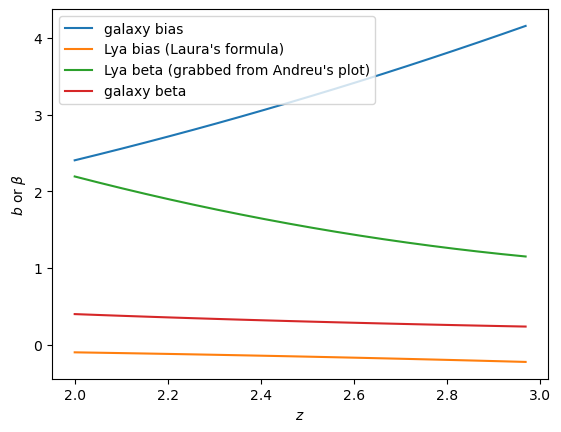

In [22]:
zsamp = np.linspace(2,2.969,20)
plt.plot(zsamp, bias_law_gal(zsamp),label="galaxy bias")
plt.plot(zsamp, bias_law_lya(zsamp),label="Lya bias (Laura's formula)")
plt.plot(zsamp, beta_law_lya(zsamp),label="Lya beta (grabbed from Andreu's plot)")
plt.plot(zsamp, beta_law_gal(zsamp, bias_law_gal), label="galaxy beta")
plt.legend()
plt.xlabel("$z$")
plt.ylabel("$b$ or $\\beta$")

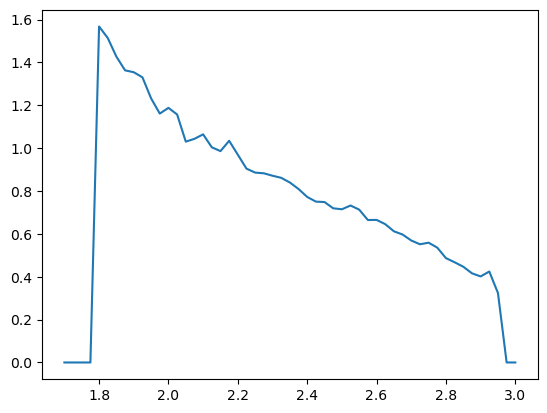

In [23]:
# also load n(z) of galaxies here:
fin = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/nz-gal-true-z1.8-3.0-all-boxes-40bin.txt")
plt.plot(fin[:,0],fin[:,1])
# let's get interpolation function
nz_gal_law = interpolate.interp1d(fin[:,0],fin[:,1],fill_value=0,bounds_error=False)

In [165]:
# w_pp
theta = 20 # arcmin
Dz=0.05
zbin_edges = np.linspace(2,3,21)
zbin_cen = (zbin_edges[1:] + zbin_edges[:-1])/2.

w_pp_full_rsd = np.zeros(len(zbin_cen))
r_pp_full_rsd = np.zeros(len(zbin_cen))

beta_law = beta_law_gal
bias_law = bias_law_gal

for ii, zmean in enumerate(zbin_cen):
    if ii in [5,10,15]:
        print(ii)
    w_pp_full_rsd[ii] = wnotLimber_rsd_theta_auto(zmean, Dz, theta, beta_law, bias_law, tracer="gal")
    r_pp_full_rsd[ii] = w_pp_full_rsd[ii]/wnotLimber_theta(zmean, Dz, theta)

5
10
15


In [153]:
# w_ss
theta = 20 # arcmin
Dz=0.05
zbin_edges = np.linspace(2,3,21)
zbin_cen = (zbin_edges[1:] + zbin_edges[:-1])/2.

w_ss_full_rsd = np.zeros(len(zbin_cen))
r_ss_full_rsd = np.zeros(len(zbin_cen))

beta_law = beta_law_lya
bias_law = bias_law_lya

for ii, zmean in enumerate(zbin_cen):
    if ii in [5,10,15]:
        print(ii)
    w_ss_full_rsd[ii] = wnotLimber_rsd_theta_auto(zmean, Dz, theta, beta_law, bias_law, tracer="lya")
    r_ss_full_rsd[ii] = w_ss_full_rsd[ii]/wnotLimber_theta(zmean, Dz, theta)

5
10
15


In [142]:
# cross-correlation: need to use 2 n(z)'s:
theta = 20 # arcmin
Dz=0.05
zbin_edges = np.linspace(2,3,21)
zbin_cen = (zbin_edges[1:] + zbin_edges[:-1])/2.
nz_law = nz_gal_law
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya # this is for lya
bias_law1 = bias_law_gal
bias_law2 = bias_law_lya

w_sp_full_rsd = np.zeros(len(zbin_cen))
#r_ss_full_rsd = np.zeros(len(zbin_cen))

for ii, zmean in enumerate(zbin_cen):
    if ii in [5,10,15]:
        print(ii)
    beta = omega_m_z(zmean)**0.55/bias_law(zmean)
    beta2 = beta_law_lya(zmean)
    w_sp_full_rsd[ii] = wnotLimber_rsd_theta_cross(zmean, Dz, nz_law, theta, beta_law1, 
                                               beta_law2=beta_law2, bias_law1=bias_law1, bias_law2=bias_law2)

5
10
15


/tmp/ipykernel_1031067/3227841581.py:33: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z1,zmin1,zmax1,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


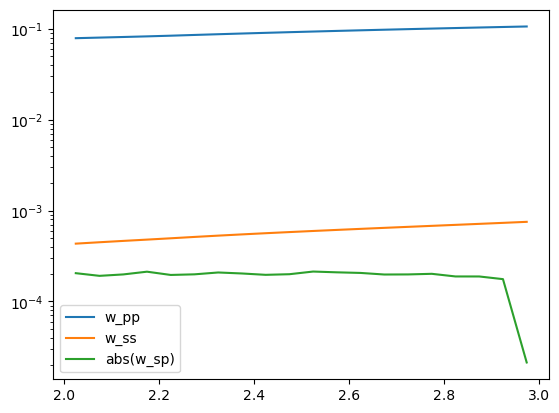

In [166]:
plt.plot(zbin_cen, w_pp_full_rsd,label="w_pp")
plt.plot(zbin_cen, w_ss_full_rsd,label="w_ss")
plt.plot(zbin_cen, abs(w_sp_full_rsd),label="abs(w_sp)")
plt.yscale("log")
plt.legend()

In [168]:
# measurements:
root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/"
data=np.loadtxt(root+'nz_estimate-raw-wpp-theta-min-10-max-30.dat')

Text(0.5, 1.0, 'Double integ. + RSD, $\\theta=20$ arcmin, $\\Delta z = 0.05$')

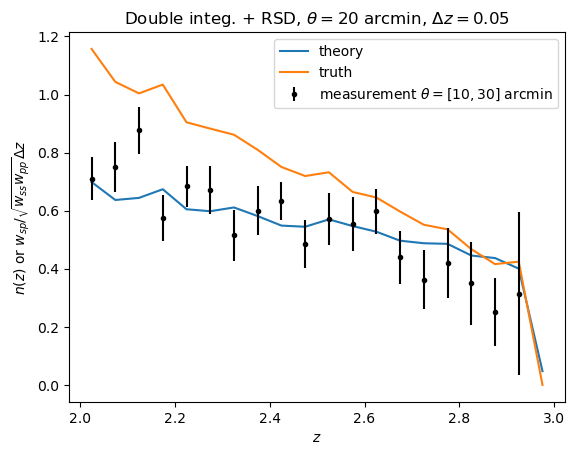

In [169]:
a = abs(w_sp_full_rsd)#*bias_law_lya(zbin_cen)*bias_law(zbin_cen))
b = w_ss_full_rsd
c = w_pp_full_rsd
plt.plot(zbin_cen, a/np.sqrt(b*c)/Dz,label="theory")
plt.plot(zbin_cen, nz_gal_law(zbin_cen), label="truth")
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt='.',
             label="measurement $\\theta=[10,30]$ arcmin", color="k")
plt.legend()

plt.xlabel("$z$")
plt.ylabel("$n(z)$ or $w_{sp}/\\sqrt{w_{ss}w_{pp}}\\Delta z$")
plt.title("Double integ. + RSD, $\\theta=20$ arcmin, $\\Delta z = 0.05$")

# Investigate its effect
## Evaluate for a fixed deltaz, how does this effect changes with redshift and theta

In [340]:
#zmean=2.5
dz = 0.025
Nrp=20
Nz=20
edges = np.linspace(2,3,40+1)
meanz = (edges[1:]+edges[:-1])/2.
meanz = meanz[::2]
print(meanz)

#Rp= np.logspace(0,2,Nrp)
Theta= np.logspace(1,np.log10(50),Nrp)
#Dz=np.logspace(-2,np.log10(0.8),Ndz)

#Dev_rp_dz=np.zeros((Nrp,Ndz))
#Ratio_rp_dz=np.zeros((Nrp,Ndz))
Dev_theta_dz=np.zeros((Nrp,Nz))
Ratio_theta_dz=np.zeros((Nrp,Nz))

print(np.shape(Dev_theta_dz))

[2.0125 2.0625 2.1125 2.1625 2.2125 2.2625 2.3125 2.3625 2.4125 2.4625
 2.5125 2.5625 2.6125 2.6625 2.7125 2.7625 2.8125 2.8625 2.9125 2.9625]
(20, 20)


In [368]:
for itheta in range(Nrp):
    print(itheta)
    for jz in range(Nz):
        no_rsd=wnotLimber_theta(meanz[jz], dz, Theta[itheta])
        beta = omega_m_z(meanz[jz])**0.55/bias_law(round(meanz[jz],4))
        with_rsd=wnotLimber_rsd_theta(meanz[jz], dz, Theta[itheta], beta)
        Dev_theta_dz[itheta][jz]=(with_rsd-no_rsd)/with_rsd
        Ratio_theta_dz[itheta][jz]=(with_rsd)/no_rsd

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, '$(w_{\\rm RSD})/w_{\\rm no RSD}$ for $\\Delta z=0.025$')

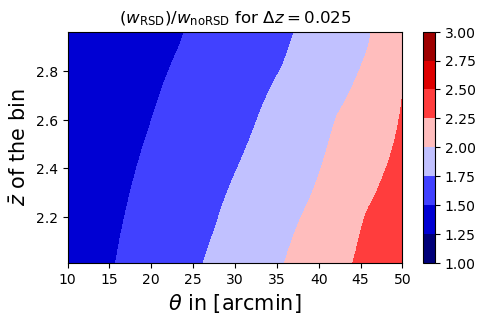

In [386]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 3 # sets plot size
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
levels = np.linspace(1,3,9)

cpf = ax.contourf(Theta, meanz,  Ratio_theta_dz.T, len(levels), levels=levels, cmap='seismic',vmin=1, vmax=3)
#ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel('$\\theta$ in [arcmin]',fontsize=15)
ax.set_ylabel('$\\bar{ z}$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$w_{\rm RSD}/w_{\rm no RSD}$ for $\Delta z=0.025$')

In [387]:
# if fix beta:
for itheta in range(Nrp):
    print(itheta)
    for jz in range(Nz):
        no_rsd=wnotLimber_theta(meanz[jz], dz, Theta[itheta])
        beta = 0.3892621984717692
        with_rsd=wnotLimber_rsd_theta(meanz[jz], dz, Theta[itheta], beta)
        Dev_theta_dz[itheta][jz]=(with_rsd-no_rsd)/with_rsd
        Ratio_theta_dz[itheta][jz]=(with_rsd)/no_rsd

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, '$w_{\\rm RSD}/w_{\\rm no RSD}$ for $\\Delta z=0.025$, with fixed beta')

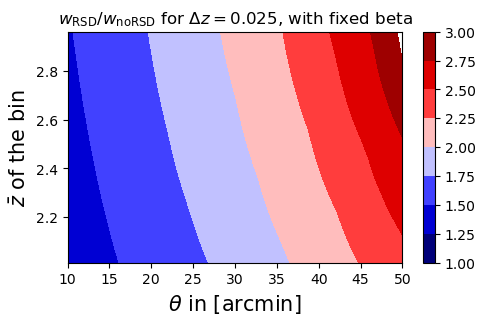

In [389]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 3 # sets plot size
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
levels = np.linspace(1,3,9)

cpf = ax.contourf(Theta, meanz,  Ratio_theta_dz.T, len(levels), levels=levels, cmap='seismic',vmin=1, vmax=3)
#ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel('$\\theta$ in [arcmin]',fontsize=15)
ax.set_ylabel('$\\bar{ z}$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$w_{\rm RSD}/w_{\rm no RSD}$ for $\Delta z=0.025$, with fixed beta')

In [390]:
#zmean=2.5
dz = 0.1 # 10 bins
Nrp=20
Nz=10
edges = np.linspace(2,3,10+1)
meanz = (edges[1:]+edges[:-1])/2.
print(meanz)

#Rp= np.logspace(0,2,Nrp)
Theta= np.logspace(1,np.log10(50),Nrp)
#Dz=np.logspace(-2,np.log10(0.8),Ndz)

#Dev_rp_dz=np.zeros((Nrp,Ndz))
#Ratio_rp_dz=np.zeros((Nrp,Ndz))
Dev_theta_dz=np.zeros((Nrp,Nz))
Ratio_theta_dz=np.zeros((Nrp,Nz))

print(np.shape(Dev_theta_dz))

[2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75 2.85 2.95]
(20, 10)


In [391]:
for itheta in range(Nrp):
    print(itheta)
    for jz in range(Nz):
        no_rsd=wnotLimber_theta(meanz[jz], dz, Theta[itheta])
        beta = omega_m_z(meanz[jz])**0.55/bias_law(round(meanz[jz],4))
        with_rsd=wnotLimber_rsd_theta(meanz[jz], dz, Theta[itheta], beta)
        Dev_theta_dz[itheta][jz]=(with_rsd-no_rsd)/with_rsd
        Ratio_theta_dz[itheta][jz]=(with_rsd)/no_rsd

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, '$w_{\\rm RSD}/w_{\\rm no RSD}$ for $\\Delta z=0.1$')

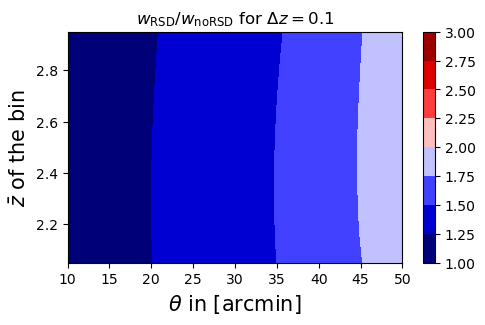

In [393]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 3 # sets plot size
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
levels = np.linspace(1,3,9)

cpf = ax.contourf(Theta, meanz,  Ratio_theta_dz.T, len(levels), levels=levels, cmap='seismic',vmin=1, vmax=3)
#ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel('$\\theta$ in [arcmin]',fontsize=15)
ax.set_ylabel('$\\bar{ z}$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$w_{\rm RSD}/w_{\rm no RSD}$ for $\Delta z=0.1$')

### wss

In [386]:
#zmean=2.5
dz = 0.025
Nrp=20
Nz=20
edges = np.linspace(2,3,40+1)
meanz = (edges[1:]+edges[:-1])/2.
meanz = meanz[::2]
print(meanz)

#Rp= np.logspace(0,2,Nrp)
Theta= np.logspace(1,np.log10(50),Nrp)
#Dz=np.logspace(-2,np.log10(0.8),Ndz)

#Dev_rp_dz=np.zeros((Nrp,Ndz))
#Ratio_rp_dz=np.zeros((Nrp,Ndz))
Dev_theta_dz=np.zeros((Nrp,Nz))
Ratio_theta_dz=np.zeros((Nrp,Nz))

print(np.shape(Dev_theta_dz))

for itheta in range(Nrp):
    print(itheta)
    for jz in range(Nz):
        no_rsd=wnotLimber_theta(meanz[jz], dz, Theta[itheta])
        beta = beta_law_lya(meanz[jz])
        with_rsd=wnotLimber_rsd_theta(meanz[jz], dz, Theta[itheta], beta)
        Dev_theta_dz[itheta][jz]=(with_rsd-no_rsd)/with_rsd
        Ratio_theta_dz[itheta][jz]=(with_rsd)/no_rsd

[2.0125 2.0625 2.1125 2.1625 2.2125 2.2625 2.3125 2.3625 2.4125 2.4625
 2.5125 2.5625 2.6125 2.6625 2.7125 2.7625 2.8125 2.8625 2.9125 2.9625]
(20, 20)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, '$w^{\\rm RSD}_{ss}/w^{\\rm no RSD}_{ss}$ for $\\Delta z=0.025$')

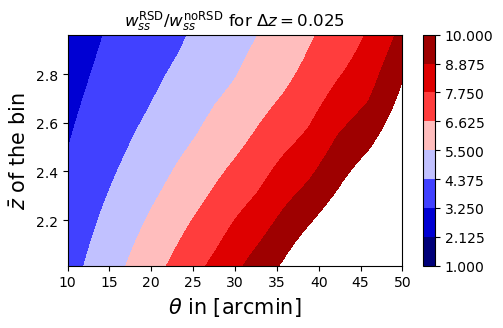

In [387]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 3 # sets plot size
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
levels = np.linspace(1,10,9)

cpf = ax.contourf(Theta, meanz,  Ratio_theta_dz.T, len(levels), levels=levels, cmap='seismic',vmin=1, vmax=10)
#ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel('$\\theta$ in [arcmin]',fontsize=15)
ax.set_ylabel('$\\bar{ z}$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$w^{\rm RSD}_{ss}/w^{\rm no RSD}_{ss}$ for $\Delta z=0.025$')

In [345]:
#zmean=2.5
dz = 0.1 # 10 bins
Nrp=20
Nz=10
edges = np.linspace(2,3,10+1)
meanz = (edges[1:]+edges[:-1])/2.
print(meanz)

#Rp= np.logspace(0,2,Nrp)
Theta= np.logspace(1,np.log10(50),Nrp)
#Dz=np.logspace(-2,np.log10(0.8),Ndz)

#Dev_rp_dz=np.zeros((Nrp,Ndz))
#Ratio_rp_dz=np.zeros((Nrp,Ndz))
Dev_theta_dz=np.zeros((Nrp,Nz))
Ratio_theta_dz=np.zeros((Nrp,Nz))

print(np.shape(Dev_theta_dz))

for itheta in range(Nrp):
    print(itheta)
    for jz in range(Nz):
        no_rsd=wnotLimber_theta(meanz[jz], dz, Theta[itheta])
        beta = beta_law_lya(meanz[jz])
        with_rsd=wnotLimber_rsd_theta(meanz[jz], dz, Theta[itheta], beta)
        Dev_theta_dz[itheta][jz]=(with_rsd-no_rsd)/with_rsd
        Ratio_theta_dz[itheta][jz]=(with_rsd)/no_rsd

[2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75 2.85 2.95]
(20, 10)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, '$w^{\\rm RSD}_{ss}/w^{\\rm no RSD}_{ss}$ for $\\Delta z=0.1$')

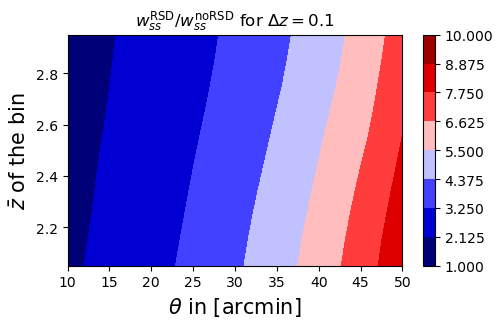

In [349]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 3 # sets plot size
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
levels = np.linspace(1,10,9)

cpf = ax.contourf(Theta, meanz,  Ratio_theta_dz.T, len(levels), levels=levels, cmap='seismic',vmin=1, vmax=10)
#ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel('$\\theta$ in [arcmin]',fontsize=15)
ax.set_ylabel('$\\bar{ z}$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$w^{\rm RSD}_{ss}/w^{\rm no RSD}_{ss}$ for $\Delta z=0.1$')

In [389]:
#zmean=2.5
dz = 0.025
Nrp=20
Nz=20
edges = np.linspace(2,3,40+1)
meanz = (edges[1:]+edges[:-1])/2.
meanz = meanz[::2]
print(meanz)

#Rp= np.logspace(0,2,Nrp)
Theta= np.logspace(1,np.log10(50),Nrp)
#Dz=np.logspace(-2,np.log10(0.8),Ndz)

#Dev_rp_dz=np.zeros((Nrp,Ndz))
#Ratio_rp_dz=np.zeros((Nrp,Ndz))
Dev_theta_dz=np.zeros((Nrp,Nz))
Ratio_theta_dz=np.zeros((Nrp,Nz))

print(np.shape(Dev_theta_dz))

for itheta in range(Nrp):
    print(itheta)
    for jz in range(Nz):
        no_rsd=wnotLimber_theta(meanz[jz], dz, Theta[itheta])
        beta = 1.6
        with_rsd=wnotLimber_rsd_theta(meanz[jz], dz, Theta[itheta], beta)
        Dev_theta_dz[itheta][jz]=(with_rsd-no_rsd)/with_rsd
        Ratio_theta_dz[itheta][jz]=(with_rsd)/no_rsd

[2.0125 2.0625 2.1125 2.1625 2.2125 2.2625 2.3125 2.3625 2.4125 2.4625
 2.5125 2.5625 2.6125 2.6625 2.7125 2.7625 2.8125 2.8625 2.9125 2.9625]
(20, 20)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, '$w^{\\rm RSD}_{ss}/w^{\\rm no RSD}_{ss}$ for $\\Delta z=0.025$, $\\beta=1.6$')

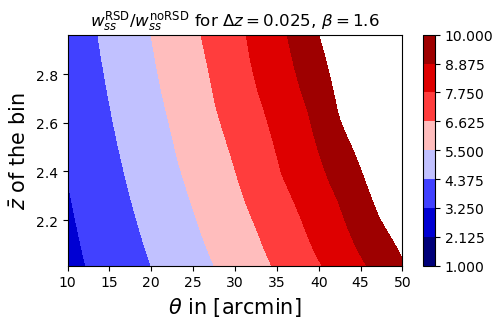

In [391]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 3 # sets plot size
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
levels = np.linspace(1,10,9)

cpf = ax.contourf(Theta, meanz,  Ratio_theta_dz.T, len(levels), levels=levels, cmap='seismic',vmin=1, vmax=10)
#ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel('$\\theta$ in [arcmin]',fontsize=15)
ax.set_ylabel('$\\bar{ z}$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$w^{\rm RSD}_{ss}/w^{\rm no RSD}_{ss}$ for $\Delta z=0.025$, $\beta=1.6$')

In [392]:
#zmean=2.5
dz = 0.1 # 10 bins
Nrp=20
Nz=10
edges = np.linspace(2,3,10+1)
meanz = (edges[1:]+edges[:-1])/2.
print(meanz)

#Rp= np.logspace(0,2,Nrp)
Theta= np.logspace(1,np.log10(50),Nrp)
#Dz=np.logspace(-2,np.log10(0.8),Ndz)

#Dev_rp_dz=np.zeros((Nrp,Ndz))
#Ratio_rp_dz=np.zeros((Nrp,Ndz))
Dev_theta_dz=np.zeros((Nrp,Nz))
Ratio_theta_dz=np.zeros((Nrp,Nz))

print(np.shape(Dev_theta_dz))

for itheta in range(Nrp):
    print(itheta)
    for jz in range(Nz):
        no_rsd=wnotLimber_theta(meanz[jz], dz, Theta[itheta])
        beta = 1.6
        with_rsd=wnotLimber_rsd_theta(meanz[jz], dz, Theta[itheta], beta)
        Dev_theta_dz[itheta][jz]=(with_rsd-no_rsd)/with_rsd
        Ratio_theta_dz[itheta][jz]=(with_rsd)/no_rsd

[2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75 2.85 2.95]
(20, 10)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, '$w^{\\rm RSD}_{ss}/w^{\\rm no RSD}_{ss}$ for $\\Delta z=0.1$, $\\beta=1.6$')

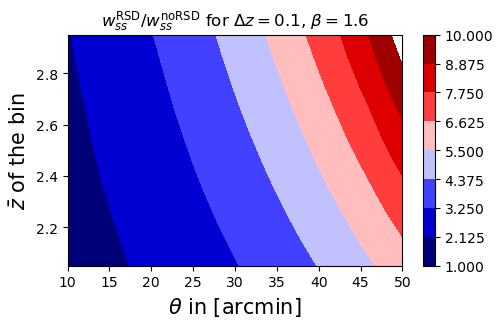

In [395]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 3 # sets plot size
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
levels = np.linspace(1,10,9)

cpf = ax.contourf(Theta, meanz,  Ratio_theta_dz.T, len(levels), levels=levels, cmap='seismic',vmin=1, vmax=10)
#ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel('$\\theta$ in [arcmin]',fontsize=15)
ax.set_ylabel('$\\bar{ z}$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$w^{\rm RSD}_{ss}/w^{\rm no RSD}_{ss}$ for $\Delta z=0.1$, $\beta=1.6$')

In [384]:
# cross:
#zmean=2.5
dz = 0.025
Nrp=10
Nz=10
edges = np.linspace(2,3,40+1)
meanz = (edges[1:]+edges[:-1])/2.
meanz = meanz[::4]
print(meanz)

#Rp= np.logspace(0,2,Nrp)
Theta= np.logspace(1,np.log10(50),Nrp)
#Dz=np.logspace(-2,np.log10(0.8),Ndz)

#Dev_rp_dz=np.zeros((Nrp,Ndz))
#Ratio_rp_dz=np.zeros((Nrp,Ndz))
Dev_theta_dz=np.zeros((Nrp,Nz))
Ratio_theta_dz=np.zeros((Nrp,Nz))

print(np.shape(Dev_theta_dz))

nz_law = nz_gal_law
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya # this is for lya
bias_law1 = bias_law_gal
bias_law2 = bias_law_lya

Ratio_theta_dz=np.zeros((Nrp,Nz))

#nz_array = np.linspace(1.8,3.0,241)
#nz1 = nz_gal_law(nz_array)

for itheta in range(Nrp):
    print(itheta)
    for ii, zmean in enumerate(meanz):
        beta = omega_m_z(zmean)**0.55/bias_law(zmean)
        beta2 = beta_law_lya(zmean)
        with_rsd = wnotLimber_rsd_theta_cross(zmean, dz, nz_law, Theta[itheta], beta_law1, 
                                                   beta_law2=beta_law2, bias_law1=bias_law1, bias_law2=bias_law2)
        
        #nz2 = np.zeros(len(nz_array))
        #ind *= (nz_array>=2.0)&(nz_array<=3.0)
        #ind = (nz_array>=zmean-dz/2.) & (nz_array<=zmean+dz/2.)
        #nz2[ind]=1
        #nz2 = nz2/sum(nz2)/(nz_array[1]-nz_array[0]) # normalize
        #no_rsd = wnotLimber_theta_n(nz_array, nz1, nz2, Theta[itheta])
        no_rsd = wnotLimber_theta_cross(zmean, dz, nz_law, Theta[itheta],
                              bias_law1=bias_law1, bias_law2=bias_law2)
        Ratio_theta_dz[itheta, ii] = with_rsd/no_rsd

[2.0125 2.1125 2.2125 2.3125 2.4125 2.5125 2.6125 2.7125 2.8125 2.9125]
(10, 10)
0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$w^{\\rm RSD}_{sp}/w^{\\rm no RSD}_{sp}$ for $\\Delta z=0.025$')

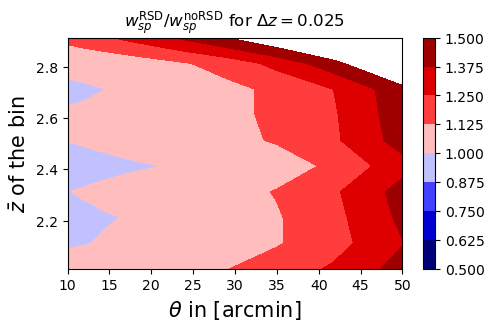

In [385]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 3 # sets plot size
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
levels = np.linspace(0.5,1.5,9)

cpf = ax.contourf(Theta, meanz,  Ratio_theta_dz.T, len(levels), levels=levels, cmap='seismic')
#ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel('$\\theta$ in [arcmin]',fontsize=15)
ax.set_ylabel('$\\bar{ z}$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$w^{\rm RSD}_{sp}/w^{\rm no RSD}_{sp}$ for $\Delta z=0.025$')

In [380]:
# cross:
#zmean=2.5
dz = 0.1
Nrp=10
Nz=10
edges = np.linspace(2,3,10+1)
meanz = (edges[1:]+edges[:-1])/2.
print(meanz)

#Rp= np.logspace(0,2,Nrp)
Theta= np.logspace(1,np.log10(50),Nrp)
#Dz=np.logspace(-2,np.log10(0.8),Ndz)

#Dev_rp_dz=np.zeros((Nrp,Ndz))
#Ratio_rp_dz=np.zeros((Nrp,Ndz))
Dev_theta_dz=np.zeros((Nrp,Nz))
Ratio_theta_dz=np.zeros((Nrp,Nz))

print(np.shape(Dev_theta_dz))

nz_law = nz_gal_law
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya # this is for lya
bias_law1 = bias_law_gal
bias_law2 = bias_law_lya

Ratio_theta_dz=np.zeros((Nrp,Nz))

#nz_array = np.linspace(1.8,3.0,241)
#nz1 = nz_gal_law(nz_array)

for itheta in range(Nrp):
    print(itheta)
    for ii, zmean in enumerate(meanz):
        beta = omega_m_z(zmean)**0.55/bias_law(zmean)
        beta2 = beta_law_lya(zmean)
        with_rsd = wnotLimber_rsd_theta_cross(zmean, dz, nz_law, Theta[itheta], beta_law1, 
                                                   beta_law2=beta_law2, bias_law1=bias_law1, bias_law2=bias_law2)
        
        #nz2 = np.zeros(len(nz_array))
        #ind *= (nz_array>=2.0)&(nz_array<=3.0)
        #ind = (nz_array>=zmean-dz/2.) & (nz_array<=zmean+dz/2.)
        #nz2[ind]=1
        #nz2 = nz2/sum(nz2)/(nz_array[1]-nz_array[0]) # normalize
        #no_rsd = wnotLimber_theta_n(nz_array, nz1, nz2, Theta[itheta])
        no_rsd = wnotLimber_theta_cross(zmean, dz, nz_law, Theta[itheta],
                              bias_law1=bias_law1, bias_law2=bias_law2)
        Ratio_theta_dz[itheta, ii] = with_rsd/no_rsd

[2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75 2.85 2.95]
(10, 10)
0
1
2
3
4
5
6
7
8
9


Text(0.5, 1.0, '$w^{\\rm RSD}_{sp}/w^{\\rm no RSD}_{sp}$ for $\\Delta z=0.1$')

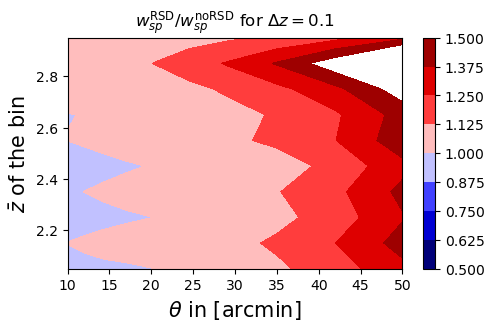

In [383]:
plt.rcParams['text.usetex'] = False
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = 5.4, 3 # sets plot size
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
levels = np.linspace(0.5,1.5,9)

cpf = ax.contourf(Theta, meanz,  Ratio_theta_dz.T, len(levels), levels=levels, cmap='seismic')
#ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel('$\\theta$ in [arcmin]',fontsize=15)
ax.set_ylabel('$\\bar{ z}$ of the bin',fontsize=15)
plt.colorbar(cpf)
plt.title(r'$w^{\rm RSD}_{sp}/w^{\rm no RSD}_{sp}$ for $\Delta z=0.1$')

# fit to data

In [172]:
# now let's compute this as a function of theta, then combine the theta bins:
Ndz=2
Z_20=[2.025+i*0.05 for i in range(20)]
Z_40=[2.0125+i*0.025 for i in range(40)]

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
#Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)

W_theta1030_dz025=np.zeros((Ntheta,40))
#W_theta3050_dz025=np.zeros((Ntheta,40))
W_theta1030_dz05=np.zeros((Ntheta,20))
#W_theta3050_dz05=np.zeros((Ntheta,20))

print(np.shape(W_theta1030_dz025))

(10, 40)


In [177]:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(20):
        zmean=Z_20[jdz]
        dz=0.05
        not_limb_1030=wnotLimber_theta(zmean,dz, Theta_10_30[itheta])
        #not_limb_3050=wnotLimber_theta(zmean,dz, Theta_30_50[itheta])
        
        W_theta1030_dz05[itheta][jdz]=not_limb_1030
        #W_theta3050_dz05[itheta][jdz]=not_limb_3050
        #print(not_limb_1030)

0
1
2
3
4
5
6
7
8
9


In [175]:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(40):
        zmean=Z_40[jdz]
        dz=0.025
        not_limb_1030=wnotLimber_theta(zmean,dz, Theta_10_30[itheta])
        #not_limb_3050=wnotLimber_theta(zmean,dz, Theta_30_50[itheta])
        
        W_theta1030_dz025[itheta][jdz]=not_limb_1030
        #W_theta3050_dz025[itheta][jdz]=not_limb_3050

0
1
2
3
4
5
6
7
8
9


In [176]:
# wpp data
root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/for_william/"
data=np.loadtxt(root+'mock0-w_pp-norsd-theta-min-10-max-30-zbin-40.txt')
Z_025,wpp_10_30_z025,err_wpp_10_30_z025=data[:-1,0],data[:-1,1],data[:-1,2]

data=np.loadtxt(root+'mock0-w_pp-norsd-theta-min-10-max-30-zbin-20.txt')
Z_05,wpp_10_30_z05,err_wpp_10_30_z05=data[:-1,0],data[:-1,1],data[:-1,2]

In [141]:
# power law for the scale weighting;
alpha=2

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
Theta1_10_30= np.logspace(np.log10(9),np.log10(32),Ntheta+1)
DTheta_10_30=np.array([Theta1_10_30[i+1]-Theta1_10_30[i] for i in range(Ntheta)])

Wtheta_1030_dz025_mean=[np.sum(W_theta1030_dz025[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_1030_dz05_mean=[np.sum(W_theta1030_dz05[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_10_30_dz025=Wtheta_1030_dz025_mean[:-1]*bias_law_gal(Z_025)**2
Wb2_10_30_dz05=Wtheta_1030_dz05_mean[:-1]*bias_law_gal(Z_05)**2


"""
Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)
Theta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)
DTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])


Wtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2
"""

'\nTheta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)\nTheta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)\nDTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])\n\n\nWtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]\nWtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]\n\nWb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2\nWb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2\n'

Text(0.5, 1.0, '$\\alpha=2$, no RSD')

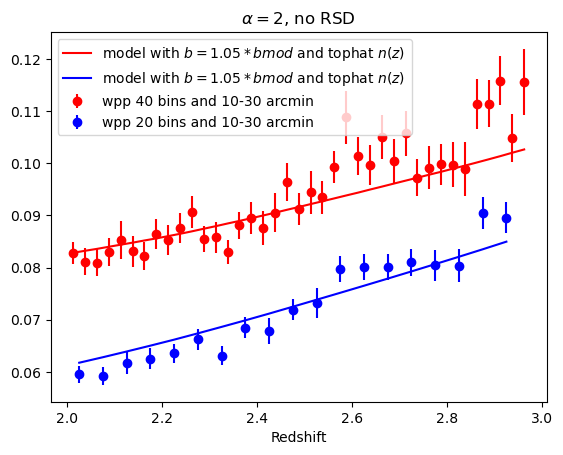

In [187]:
# mismatch in bias between model and data:
#eta_bias=0.87
eta_bias=1.05

plt.errorbar(Z_025,wpp_10_30_z025,yerr=err_wpp_10_30_z025,color='red',linestyle='',marker='o',label='wpp 40 bins and 10-30 arcmin')
plt.errorbar(Z_05,wpp_10_30_z05,yerr=err_wpp_10_30_z05,color='blue',linestyle='',marker='o',label='wpp 20 bins and 10-30 arcmin')

plt.plot(Z_025,Wb2_10_30_dz025*eta_bias**2,color='red',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.plot(Z_05,Wb2_10_30_dz05*eta_bias**2,color='blue',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.xlabel('Redshift')
plt.legend()
plt.title("$\\alpha=2$, no RSD")
#plt.savefig('test_newbias.png')

In [178]:
# now rsd:
# now let's compute this as a function of theta, then combine the theta bins:
Ndz=2
Z_20=[2.025+i*0.05 for i in range(20)]
Z_40=[2.0125+i*0.025 for i in range(40)]

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
#Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)

W_theta1030_dz025_rsd=np.zeros((Ntheta,40))
#W_theta3050_dz025=np.zeros((Ntheta,40))
W_theta1030_dz05_rsd=np.zeros((Ntheta,20))
#W_theta3050_dz05=np.zeros((Ntheta,20))

print(np.shape(W_theta1030_dz025_rsd))

(10, 40)


In [179]:
# here need to compute beta and update it for every z:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(19):
        zmean=Z_20[jdz]
        dz=0.05
        beta = omega_m_z(zmean)**0.55/bias_law(zmean)
        not_limb_1030=wnotLimber_rsd_theta(zmean,dz, Theta_10_30[itheta], beta)
        #not_limb_3050=wnotLimber_theta(zmean,dz, Theta_30_50[itheta])
        
        W_theta1030_dz05_rsd[itheta][jdz]=not_limb_1030
        #W_theta3050_dz05[itheta][jdz]=not_limb_3050
        #print(not_limb_1030)

0
1
2
3
4
5
6
7
8
9


In [180]:
# here need to compute beta and update it for every z:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(39):
        zmean=Z_40[jdz]
        dz=0.025
        beta = omega_m_z(zmean)**0.55/bias_law(round(zmean,4))
        not_limb_1030=wnotLimber_rsd_theta(zmean,dz, Theta_10_30[itheta], beta)
        #not_limb_3050=wnotLimber_theta(zmean,dz, Theta_30_50[itheta])
        
        W_theta1030_dz025_rsd[itheta][jdz]=not_limb_1030
        #W_theta3050_dz05[itheta][jdz]=not_limb_3050
        #print(not_limb_1030)

0
1
2
3
4
5
6
7
8
9


In [184]:
# power law for the scale weighting;
alpha=2

Ntheta=10
Theta_10_30= np.logspace(np.log10(10),np.log10(30),Ntheta)
Theta1_10_30= np.logspace(np.log10(9),np.log10(32),Ntheta+1)
DTheta_10_30=np.array([Theta1_10_30[i+1]-Theta1_10_30[i] for i in range(Ntheta)])

Wtheta_1030_dz025_rsd_mean=[np.sum(W_theta1030_dz025_rsd[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_1030_dz05_rsd_mean=[np.sum(W_theta1030_dz05_rsd[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_10_30_dz025_rsd=Wtheta_1030_dz025_rsd_mean[:-1]*bias_law_gal(Z_025)**2
Wb2_10_30_dz05_rsd=Wtheta_1030_dz05_rsd_mean[:-1]*bias_law_gal(Z_05)**2


"""
Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)
Theta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)
DTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])


Wtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2
"""

'\nTheta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)\nTheta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)\nDTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])\n\n\nWtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]\nWtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]\n\nWb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2\nWb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2\n'

In [181]:
# wpp data
root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/for_william/"
data=np.loadtxt(root+'mock0-w_pp-theta-min-10-max-30-zbin-40.txt')
Z_025,wpp_10_30_z025_rsd,err_wpp_10_30_z025_rsd=data[:-1,0],data[:-1,1],data[:-1,2]

data=np.loadtxt(root+'mock0-w_pp-theta-min-10-max-30-zbin-20.txt')
Z_05,wpp_10_30_z05_rsd,err_wpp_10_30_z05_rsd=data[:-1,0],data[:-1,1],data[:-1,2]

Text(0.5, 1.0, '$\\alpha=2$, RSD')

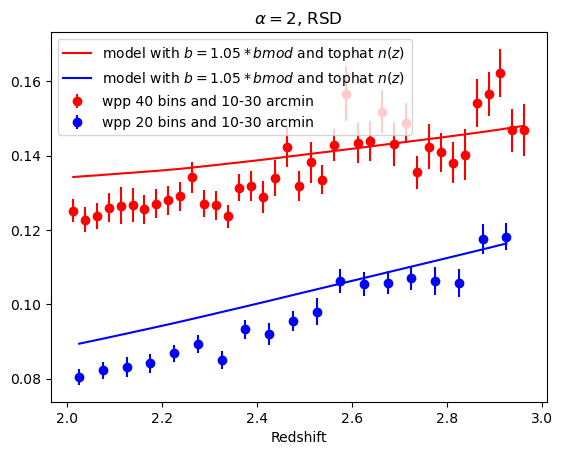

In [186]:
# mismatch in bias between model and data:
#eta_bias=0.87
eta_bias=1.05

plt.errorbar(Z_025,wpp_10_30_z025_rsd,yerr=err_wpp_10_30_z025_rsd,color='red',linestyle='',marker='o',label='wpp 40 bins and 10-30 arcmin')
plt.errorbar(Z_05,wpp_10_30_z05_rsd,yerr=err_wpp_10_30_z05_rsd,color='blue',linestyle='',marker='o',label='wpp 20 bins and 10-30 arcmin')

plt.plot(Z_025,Wb2_10_30_dz025_rsd*eta_bias**2,color='red',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.plot(Z_05,Wb2_10_30_dz05_rsd*eta_bias**2,color='blue',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.xlabel('Redshift')
plt.legend()
plt.title("$\\alpha=2$, RSD")
#plt.savefig('test_newbias.png')

Let's try some other alpha's and see what fits the best

In [196]:
# power law for the scale weighting;
alpha=0

Ntheta=10
Theta1_10_30 = np.logspace(np.log10(10),np.log10(30),Ntheta+1)
Theta_10_30= (Theta1_10_30[1:] + Theta1_10_30[:-1])/2.
DTheta_10_30=np.array([Theta1_10_30[i+1]-Theta1_10_30[i] for i in range(Ntheta)])

Wtheta_1030_dz025_mean=[np.sum(W_theta1030_dz025[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta1_10_30[-1]**(alpha+1)-Theta1_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_1030_dz05_mean=[np.sum(W_theta1030_dz05[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta1_10_30[-1]**(alpha+1)-Theta1_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_10_30_dz025=Wtheta_1030_dz025_mean[:-1]*bias_law_gal(Z_025)**2
Wb2_10_30_dz05=Wtheta_1030_dz05_mean[:-1]*bias_law_gal(Z_05)**2


"""
Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)
Theta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)
DTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])


Wtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2
"""

'\nTheta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)\nTheta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)\nDTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])\n\n\nWtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]\nWtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]\n\nWb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2\nWb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2\n'

Text(0.5, 1.0, '$\\alpha=0$, no RSD')

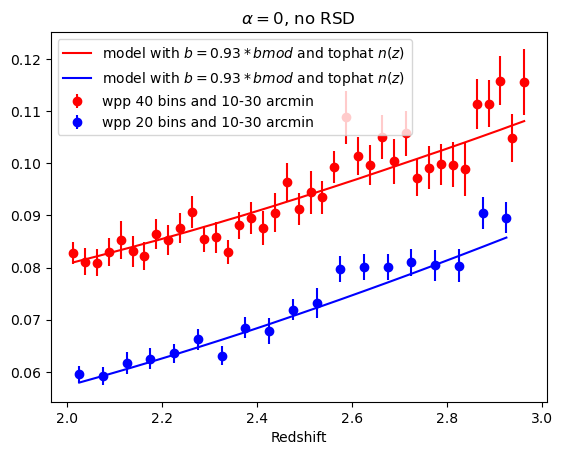

In [201]:
# mismatch in bias between model and data:
eta_bias = 0.93

plt.errorbar(Z_025,wpp_10_30_z025,yerr=err_wpp_10_30_z025,color='red',linestyle='',marker='o',label='wpp 40 bins and 10-30 arcmin')
plt.errorbar(Z_05,wpp_10_30_z05,yerr=err_wpp_10_30_z05,color='blue',linestyle='',marker='o',label='wpp 20 bins and 10-30 arcmin')

plt.plot(Z_025,Wb2_10_30_dz025*eta_bias**2,color='red',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.plot(Z_05,Wb2_10_30_dz05*eta_bias**2,color='blue',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.xlabel('Redshift')
plt.legend()
plt.title(f"$\\alpha={alpha}$, no RSD")
#plt.savefig('test_newbias.png')

In [185]:
# power law for the scale weighting;
#lpha=1

Ntheta=10
Theta1_10_30 = np.logspace(np.log10(10),np.log10(30),Ntheta+1)
Theta_10_30= (Theta1_10_30[1:] + Theta1_10_30[:-1])/2.
DTheta_10_30=np.array([Theta1_10_30[i+1]-Theta1_10_30[i] for i in range(Ntheta)])

Wtheta_1030_dz025_rsd_mean=[np.sum(W_theta1030_dz025_rsd[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta1_10_30[-1]**(alpha+1)-Theta1_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
#Wtheta_1030_dz05_rsd_mean=[np.sum(W_theta1030_dz05_rsd[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta_10_30[-1]**(alpha+1)-Theta_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]
Wtheta_1030_dz05_rsd_mean=[np.sum(W_theta1030_dz05_rsd[:,iz]*Theta_10_30**alpha*DTheta_10_30/((Theta1_10_30[-1]**(alpha+1)-Theta1_10_30[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_10_30_dz025_rsd=Wtheta_1030_dz025_rsd_mean[:-1]*bias_law_gal(Z_025)**2
Wb2_10_30_dz05_rsd=Wtheta_1030_dz05_rsd_mean[:-1]*bias_law_gal(Z_05)**2


"""
Theta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)
Theta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)
DTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])


Wtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]
Wtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]

Wb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2
Wb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2
"""

'\nTheta_30_50= np.logspace(np.log10(30),np.log10(50),Ntheta)\nTheta1_30_50= np.logspace(np.log10(29),np.log10(53),Ntheta+1)\nDTheta_30_50=np.array([Theta1_30_50[i+1]-Theta1_30_50[i] for i in range(Ntheta)])\n\n\nWtheta_3050_dz025_mean=[np.sum(W_theta3050_dz025[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(40)]\nWtheta_3050_dz05_mean=[np.sum(W_theta3050_dz05[:,iz]*Theta_30_50**alpha*DTheta_30_50/((Theta_30_50[-1]**(alpha+1)-Theta_30_50[0]**(alpha+1))/(alpha+1))) for iz in range(20)]\n\nWb2_30_50_dz025=Wtheta_3050_dz025_mean[:-1]*bias_law(Z_025)**2\nWb2_30_50_dz05=Wtheta_3050_dz05_mean[:-1]*bias_law(Z_05)**2\n'

Text(0.5, 1.0, '$\\alpha=0$, RSD')

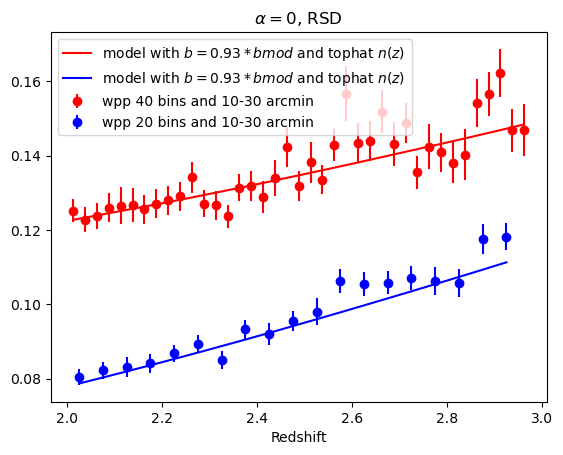

In [202]:
# mismatch in bias between model and data:
#eta_bias=0.87
#eta_bias=0.96

plt.errorbar(Z_025,wpp_10_30_z025_rsd,yerr=err_wpp_10_30_z025_rsd,color='red',linestyle='',marker='o',label='wpp 40 bins and 10-30 arcmin')
plt.errorbar(Z_05,wpp_10_30_z05_rsd,yerr=err_wpp_10_30_z05_rsd,color='blue',linestyle='',marker='o',label='wpp 20 bins and 10-30 arcmin')

plt.plot(Z_025,Wb2_10_30_dz025_rsd*eta_bias**2,color='red',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.plot(Z_05,Wb2_10_30_dz05_rsd*eta_bias**2,color='blue',label=f"model with $b={eta_bias}*bmod$ and tophat $n(z)$ ")
plt.xlabel('Redshift')
plt.legend()
plt.title(f"$\\alpha={alpha}$, RSD")
#plt.savefig('test_newbias.png')

In [213]:
! ls /pscratch/sd/q/qhang/desi-lya/results/run-0/for_william/

mock0-w_pp-norsd-theta-min-10-max-30-zbin-10.txt
mock0-w_pp-norsd-theta-min-10-max-30-zbin-20.txt
mock0-w_pp-norsd-theta-min-10-max-30-zbin-40.txt
mock0-w_pp-norsd-theta-min-10-max-30-zbin-5.txt
mock0-w_pp-norsd-theta-min-10-max-30-zbin-50.txt
mock0-w_pp-norsd-theta-min-30-max-50-zbin-20.txt
mock0-w_pp-norsd-theta-min-30-max-50-zbin-40.txt
mock0-w_pp-theta-min-10-max-30-zbin-10.txt
mock0-w_pp-theta-min-10-max-30-zbin-20-rweight-0.txt
mock0-w_pp-theta-min-10-max-30-zbin-20.txt
mock0-w_pp-theta-min-10-max-30-zbin-40.txt
mock0-w_pp-theta-min-10-max-30-zbin-5.txt
mock0-w_pp-theta-min-10-max-30-zbin-50.txt
mock0-w_pp-theta-min-30-max-50-zbin-20.txt
mock0-w_pp-theta-min-30-max-50-zbin-40.txt
nz-unknown-mock0-zmin-1.8-zmax-2.0-10bin-z_cosmo.txt
nz-unknown-mock0-zmin-1.8-zmax-2.0-20bin-z_cosmo.txt
nz-unknown-mock0-zmin-1.8-zmax-2.0-40bin-z_cosmo.txt
nz-unknown-norsd-mock0-zmin-1.8-zmax-2.0-10bin-z_cosmo.txt
nz-unknown-norsd-mock0-zmin-1.8-zmax-2.0-20bin-z_cosmo.txt
nz-unknown-norsd-mock0-zmin-

In [211]:
# test combine the theta bins:
root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/for_william/"
wptheta_20bins = np.loadtxt(root + "wpp-theta-10bins-min-10-max-30-z-20bin.txt")
wptheta_40bins = np.loadtxt(root + "wpp-theta-10bins-min-10-max-30-z-40bin.txt")

wp_20bins = np.loadtxt(root + "mock0-w_pp-theta-min-10-max-30-zbin-20.txt")
wp_40bins = np.loadtxt(root + "mock0-w_pp-theta-min-10-max-30-zbin-40.txt")

wp_combalpha = np.loadtxt(root + "wpp-thetacomb-alpha-min-10-max-30-z-20bin.txt")

In [324]:
wp_combalpha.shape

(6, 20)

In [230]:
alpha=0
Ntheta=10
Theta_10_30_edges = np.logspace(np.log10(10),np.log10(30),Ntheta+1)
Theta_10_30_bincen = (Theta_10_30_edges[1:] + Theta_10_30_edges[:-1])/2.
dTheta_10_30=np.array([Theta_10_30_edges[i+1]-Theta_10_30_edges[i] for i in range(Ntheta)])
#dTheta_10_30 = 1

mean_wp_thetacomb_20bins = np.zeros(20)
Wtheta_1030_dz05_rsd_mean_check = np.zeros(20)
for ii in range(20):
    #denom = (Theta_10_30_edges[-1]**(alpha+1)-Theta_10_30_edges[0]**(alpha+1))/(alpha+1)
    denom = sum(Theta_10_30_bincen**alpha*dTheta_10_30)
    mean_wp_thetacomb_20bins[ii] = sum(wptheta_20bins[:10,ii]*Theta_10_30_bincen**alpha*dTheta_10_30)/denom
    Wtheta_1030_dz05_rsd_mean_check[ii] = sum(W_theta1030_dz05_rsd[:,ii]*Theta_10_30_bincen**alpha*dTheta_10_30)/denom
    
mean_wp_thetacomb_40bins = np.zeros(40)
for ii in range(40):
    mean_wp_thetacomb_40bins[ii] = sum(wptheta_40bins[:10,ii]*Theta_10_30_bincen**alpha*dTheta_10_30)/sum(Theta_10_30_bincen**alpha*dTheta_10_30)

Text(0.5, 1.0, 'With RSD 20 bins, bias law * 1.00')

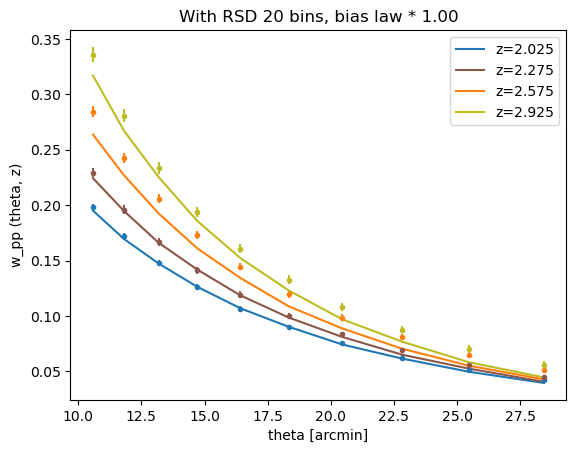

In [226]:
for ii in [0,5,11,18]:
    bg = bias_law(Z_20[ii])
    plt.plot(Theta_10_30_bincen, W_theta1030_dz05_rsd[:,ii]*bg**2,color=f'C{ii}',label=f"z={round(Z_20[ii],3)}")
    plt.errorbar(Theta_10_30_bincen, wptheta_20bins[:10,ii],yerr =wptheta_20bins[10:,ii], fmt='.',color=f'C{ii}')
plt.xlabel("theta [arcmin]")
plt.ylabel("w_pp (theta, z)")   
plt.legend()
plt.title("With RSD 20 bins, bias law * 1.00")

Text(0, 0.5, 'wpp(theta, z) Combined / wpp(z)')

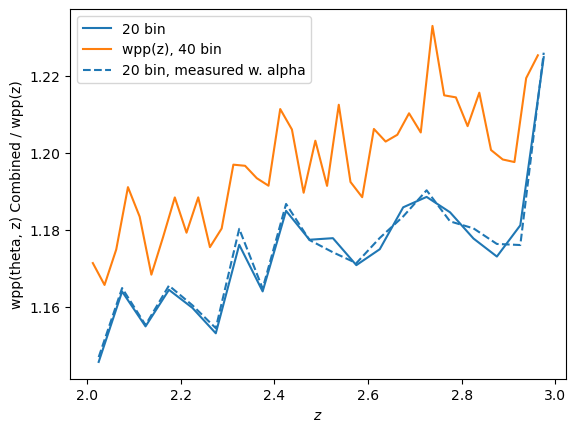

In [231]:
plt.plot(Z_20, mean_wp_thetacomb_20bins/ wp_20bins[:,1],'-',label="20 bin")
#plt.plot(wp_20bins[:,0], wp_20bins[:,1], label="Full bin")
#plt.legend()

plt.plot(Z_40[:-1], mean_wp_thetacomb_40bins[:-1]/wpp_10_30_z025_rsd,'-',label="wpp(z), 40 bin")
#plt.plot(Z_025, wpp_10_30_z025_rsd, label="Full bin")

plt.plot(Z_20, wp_combalpha[1,:]/wp_20bins[:,1], color="C0", ls='--', label="20 bin, measured w. alpha")
plt.legend()
plt.xlabel("$z$")
plt.ylabel("wpp(theta, z) Combined / wpp(z)")

In [352]:
Wtheta_1030_dz05_rsd_mean

[0.015273177798367463,
 0.014666589150247345,
 0.014089374880632187,
 0.013537714445749565,
 0.013013337296328946,
 0.012516255837357328,
 0.0120429856450666,
 0.011591439469338324,
 0.011162171612347614,
 0.010753101731035785,
 0.010361386213739058,
 0.009987791386778194,
 0.009631682865382022,
 0.009291393832687397,
 0.00896512672947764,
 0.008652627054678164,
 0.008353712528311545,
 0.008068739785169978,
 0.007796370283972029,
 0.0]

In [350]:
Wtheta_1030_dz05_rsd_mean_check

array([0.01527318, 0.01466659, 0.01408937, 0.01353771, 0.01301334,
       0.01251626, 0.01204299, 0.01159144, 0.01116217, 0.0107531 ,
       0.01036139, 0.00998779, 0.00963168, 0.00929139, 0.00896513,
       0.00865263, 0.00835371, 0.00806874, 0.00779637, 0.        ])

In [239]:
# let's also measure this with the new bias mock, and see if things fit better:
w_combalpha_newbias = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/for_william/wpp-thetacomb-alpha-min-10-max-30-z-20bin.txt")
w_combalpha_newbias_nr = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/for_william/wpp-norsd-thetacomb-alpha-min-10-max-30-z-20bin.txt")

# let's check if yaw gives consistent results as william's code with alpha=0
w_combalpha_yaw = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results/run-0/for_william/mock0-w_pp-theta-min-10-max-30-zbin-20-rweight-0.txt")

In [273]:
# now load yaw split theta measurements, and combine them in the same way:
w_thetasplit_yaw = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/w_pp-thetasplit-min-10-max-30.txt")

alpha=0
Ntheta=10
Theta_10_30_edges = np.logspace(np.log10(10),np.log10(30),Ntheta+1)
Theta_10_30_bincen = (Theta_10_30_edges[1:] + Theta_10_30_edges[:-1])/2.
dTheta_10_30=np.array([Theta_10_30_edges[i+1]-Theta_10_30_edges[i] for i in range(Ntheta)])

w_combalpha_yaw_new_jk = np.zeros((64,20))
for jk in range(64):
    data_to_get = w_thetasplit_yaw[jk, :].reshape((10,20))
    for ii in range(20):
        # combine:
        denom = sum(Theta_10_30_bincen**alpha*dTheta_10_30)
        w_combalpha_yaw_new_jk[jk, ii] = sum(data_to_get[:,ii]*Theta_10_30_bincen**alpha*dTheta_10_30)/denom
mean = np.mean(w_combalpha_yaw_new_jk, axis=0)
std = np.std(w_combalpha_yaw_new_jk, axis=0)*np.sqrt(64)
w_combalpha_yaw_new = np.c_[mean,std]

In [330]:
# also load the post processing yaw to see if we've done the right thing!
w_combalpha_yaw_new2 = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/yaw-20bin/w_pp-thetacomb-alpha-0-min-10-max-30.txt")
w_combalpha_yaw_new2.shape

(20, 66)

Text(0, 0.5, '$w_{pp}(z)$')

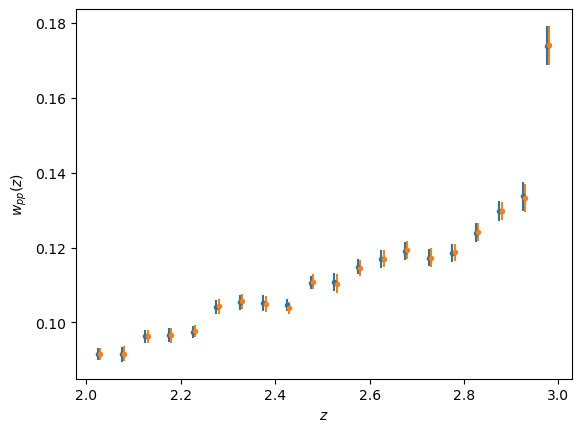

In [333]:
plt.errorbar(Z_20, w_combalpha_yaw_new2[:,0], yerr= w_combalpha_yaw_new2[:,1], fmt='.', label="yaw new implementation with alpha=0 pipe")
plt.errorbar(np.array(Z_20)+0.005, w_combalpha_newbias[1,:], yerr = w_combalpha_newbias[4,:] , fmt='.', label="William's code alpha=0")

plt.xlabel("$z$")
plt.ylabel("$w_{pp}(z)$")

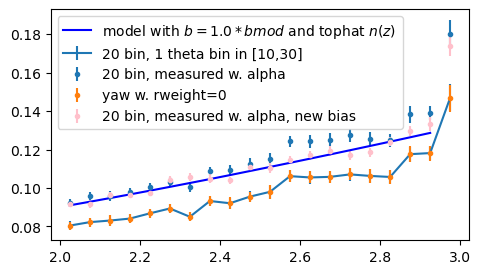

In [401]:
# okay does theory with alpha=0 agree with measurement with alpha=0?
eta_bias2 = 1.00
plt.errorbar(Z_20, wp_20bins[:,1], yerr=wp_20bins[:,2], label="20 bin, 1 theta bin in [10,30]")

plt.errorbar(Z_20, wp_combalpha[1,:], yerr = wp_combalpha[4,:] , color="C0", fmt='.', label="20 bin, measured w. alpha")
#plt.plot(Z_20, mean_wp_thetacomb_20bins, '--')

plt.errorbar(w_combalpha_yaw[:,0], w_combalpha_yaw[:,1],yerr=w_combalpha_yaw[:,2], fmt='.', label="yaw w. rweight=0")
plt.errorbar(Z_20, w_combalpha_newbias[1,:], yerr=w_combalpha_newbias[4,:],fmt='.', color='pink', label='20 bin, measured w. alpha, new bias')

plt.plot(Z_05, Wb2_10_30_dz05_rsd*eta_bias2**2,color='blue',label=f"model with $b={eta_bias2}*bmod$ and tophat $n(z)$ ")
plt.legend()

- This means yaw does the theta scaling at the pair count level (both RR, DD), rather than at w(theta) level; so when running, we need to give all theta samples and have a post processing to combine the wp in the end.
- The new bias mock is very consistent with the model.

40 bin

In [264]:
w_combalpha_newbias40 = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/for_william/wpp-thetacomb-alpha-min-10-max-30-z-40bin.txt")
w_combalpha_newbias40_nr = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/for_william/wpp-norsd-thetacomb-alpha-min-10-max-30-z-40bin.txt")
#wp_combalpha40 = np.loadtxt("/pscratch/sd/q/qhang/desi-lya/results/run-0/for_william/wpp-thetacomb-alpha-min-10-max-30-z-40bin.txt")

Text(0, 0.5, '$w_{pp}(z) = \\sum w_{pp}(\\theta, z)\\theta^{\\alpha}  \\Delta \\theta/\\sum \\theta^{\\alpha} \\Delta \\theta$')

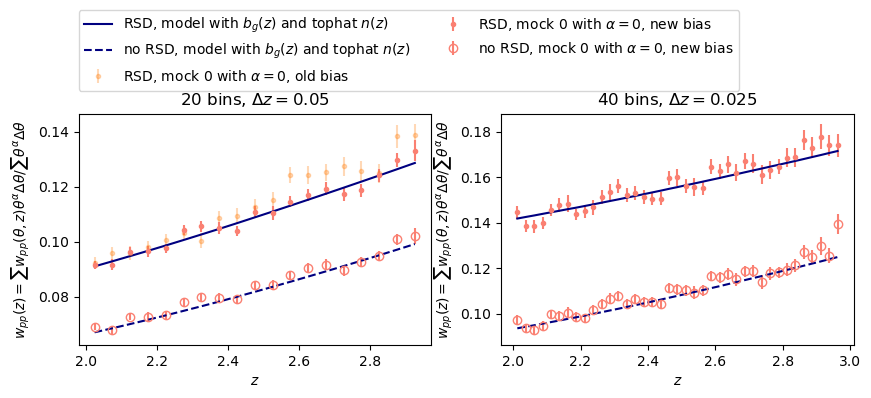

In [267]:
# also include 20 bin here: # if things are right, this is the results:
# this is the 40 bin case with thetacomb alpha=0
fig,axarr=plt.subplots(1,2,figsize=[10,3])

plt.sca(axarr[0])
plt.errorbar(Z_20[:-1], wp_combalpha[1,:-1], yerr = wp_combalpha[4,:-1] , color="C1", fmt='.', label="RSD, mock 0 with $\\alpha=0$, old bias",alpha=0.3)
plt.errorbar(Z_20[:-1], w_combalpha_newbias[1,:-1], yerr=w_combalpha_newbias[4,:-1],fmt='.', color='salmon', label='RSD, mock 0 with $\\alpha=0$, new bias')
plt.plot(Z_05, Wb2_10_30_dz05_rsd,color='navy',label=f"RSD, model with $b_g(z)$ and tophat $n(z)$ ")

plt.errorbar(Z_20[:-1], w_combalpha_newbias_nr[1,:-1], yerr=w_combalpha_newbias_nr[4,:-1],fmt='o', color='salmon', fillstyle='none',
            label='no RSD, mock 0 with $\\alpha=0$, new bias')
plt.plot(Z_05, Wb2_10_30_dz05,color='navy',ls='--', label=f"no RSD, model with $b_g(z)$ and tophat $n(z)$ ")
plt.title("20 bins, $\\Delta z = 0.05$")
plt.legend(loc=(0,1.1),ncols=2)
plt.xlabel("$z$")
plt.ylabel("$w_{pp}(z) = \\sum w_{pp}(\\theta, z)\\theta^{\\alpha}  \\Delta \\theta/\\sum \\theta^{\\alpha} \\Delta \\theta$")


plt.sca(axarr[1])
# rsd
plt.errorbar(Z_40[:-1], w_combalpha_newbias40[1,:-1], yerr=w_combalpha_newbias40[4,:-1],fmt='.', color='salmon', label='RSD, measurements with alpha=0, new bias')
plt.plot(Z_025, Wb2_10_30_dz025_rsd,color='navy',label=f"RSD, model with $b_g(z)$ and tophat $n(z)$ ")
# norsd
plt.errorbar(Z_40[:-1], w_combalpha_newbias40_nr[1,:-1], yerr=w_combalpha_newbias40_nr[4,:-1],fmt='o', color='salmon', fillstyle='none')
plt.plot(Z_025, Wb2_10_30_dz025,color='navy', ls='--', label=f"no RSD, model with $b_g(z)$ and tophat $n(z)$ ")
plt.title("40 bins, $\\Delta z = 0.025$")
plt.xlabel("$z$")
plt.ylabel("$w_{pp}(z) = \\sum w_{pp}(\\theta, z)\\theta^{\\alpha}  \\Delta \\theta/\\sum \\theta^{\\alpha} \\Delta \\theta$")

# w_ss

In [298]:
# w_ss
Z_20=[2.025+i*0.05 for i in range(20)]
Dz=0.05

Ntheta=10
Theta_10_30_edges = np.logspace(np.log10(10),np.log10(30),Ntheta+1)
Theta_10_30_bincen = (Theta_10_30_edges[1:] + Theta_10_30_edges[:-1])/2.
dTheta_10_30=np.array([Theta_10_30_edges[i+1]-Theta_10_30_edges[i] for i in range(Ntheta)])

beta_law = beta_law_lya
bias_law = bias_law_lya

Wss_theta1030_dz05_rsd=np.zeros((Ntheta,20))

# here need to compute beta and update it for every z:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(19):
        zmean=Z_20[jdz]
        beta=beta_law(zmean)
        bias=bias_law(zmean)
        theta = Theta_10_30_bincen[itheta]
        Wss_theta1030_dz05_rsd[itheta, jdz] = wnotLimber_rsd_theta(zmean, Dz, theta, beta)
        Wss_theta1030_dz05_rsd[itheta, jdz]*=bias**2

0
1
2
3
4
5
6
7
8
9


In [299]:
# combine:
alpha=0
Wss_theta1030_dz05_rsd_mean = np.zeros(20)
for ii in range(20):
    #denom = (Theta_10_30_edges[-1]**(alpha+1)-Theta_10_30_edges[0]**(alpha+1))/(alpha+1)
    denom = sum(Theta_10_30_bincen**alpha*dTheta_10_30)
    Wss_theta1030_dz05_rsd_mean[ii] = sum(Wss_theta1030_dz05_rsd[:,ii]*Theta_10_30_bincen**alpha*dTheta_10_30)/denom

In [403]:
# beta fixed version:

# w_ss
Z_20=[2.025+i*0.05 for i in range(20)]
Dz=0.05

Ntheta=10
Theta_10_30_edges = np.logspace(np.log10(10),np.log10(30),Ntheta+1)
Theta_10_30_bincen = (Theta_10_30_edges[1:] + Theta_10_30_edges[:-1])/2.
dTheta_10_30=np.array([Theta_10_30_edges[i+1]-Theta_10_30_edges[i] for i in range(Ntheta)])

#beta_law = beta_law_lya
bias_law = bias_law_lya

Wss_theta1030_dz05_rsd2=np.zeros((Ntheta,20))

# here need to compute beta and update it for every z:
for itheta in range(Ntheta):
    print(itheta)
    for jdz in range(19):
        zmean=Z_20[jdz]
        beta=1.5
        bias=bias_law(zmean)
        theta = Theta_10_30_bincen[itheta]
        Wss_theta1030_dz05_rsd2[itheta, jdz] = wnotLimber_rsd_theta(zmean, Dz, theta, beta)
        Wss_theta1030_dz05_rsd2[itheta, jdz]*=bias**2

0
1
2
3
4
5
6
7
8
9


In [404]:
# combine:
alpha=0
Wss_theta1030_dz05_rsd_mean2 = np.zeros(20)
for ii in range(20):
    #denom = (Theta_10_30_edges[-1]**(alpha+1)-Theta_10_30_edges[0]**(alpha+1))/(alpha+1)
    denom = sum(Theta_10_30_bincen**alpha*dTheta_10_30)
    Wss_theta1030_dz05_rsd_mean2[ii] = sum(Wss_theta1030_dz05_rsd2[:,ii]*Theta_10_30_bincen**alpha*dTheta_10_30)/denom

In [295]:
# load data:
root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/"
wss_measure = np.loadtxt(root + "w_ss-raw-thetacomb-alpha-0-min-10-max-30.txt")

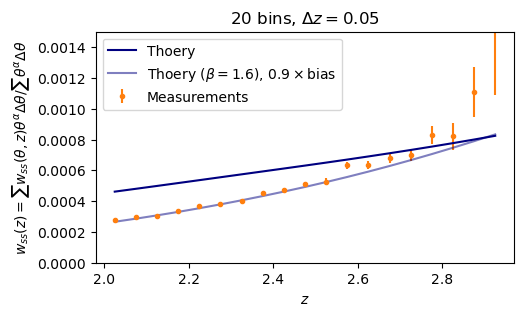

In [410]:
# plot:
eta_bias=0.9
plt.errorbar(Z_20, wss_measure[:,0], yerr=wss_measure[:,1], fmt='.', label='Measurements',color='C1')
plt.plot(Z_20[:-1], Wss_theta1030_dz05_rsd_mean[:-1], label="Thoery",color='navy')
plt.plot(Z_20[:-1], Wss_theta1030_dz05_rsd_mean2[:-1]*eta_bias**2, label=f"Thoery ($\\beta=1.6$), ${eta_bias}\\times$bias",color='navy', alpha=0.5)
plt.ylim([0,0.0015])
plt.title("20 bins, $\\Delta z = 0.05$")
plt.xlabel("$z$")
plt.ylabel("$w_{ss}(z) = \\sum w_{ss}(\\theta, z)\\theta^{\\alpha}  \\Delta \\theta/\\sum \\theta^{\\alpha} \\Delta \\theta$")
plt.legend()

# w_sp

In [309]:
#Z_20=[2.025+i*0.05 for i in range(20)]
zbin_edges = np.linspace(2,3,21)
zbin_cen = (zbin_edges[1:] + zbin_edges[:-1])/2.
Dz=0.05

Ntheta=10
Theta_10_30_edges = np.logspace(np.log10(10),np.log10(30),Ntheta+1)
Theta_10_30_bincen = (Theta_10_30_edges[1:] + Theta_10_30_edges[:-1])/2.
dTheta_10_30=np.array([Theta_10_30_edges[i+1]-Theta_10_30_edges[i] for i in range(Ntheta)])

nz_law = nz_gal_law
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya # this is for lya
bias_law1 = bias_law_gal
bias_law2 = bias_law_lya

Wsp_theta1030_dz05_rsd=np.zeros((Ntheta,20))

for itheta in range(Ntheta):
    print(itheta)
    for ii, zmean in enumerate(zbin_cen):
        theta = Theta_10_30_bincen[itheta]
        Wsp_theta1030_dz05_rsd[itheta, ii] = wnotLimber_rsd_theta_cross(zmean, Dz, nz_law, theta, beta_law1, 
                                                   beta_law2=beta_law2, bias_law1=bias_law1, 
                                                       bias_law2=bias_law2)

0
1
2
3
4


/tmp/ipykernel_1031067/3227841581.py:33: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return quad(integrate_z1,zmin1,zmax1,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]


5
6
7
8
9


In [310]:
# combine:
alpha=0
Wsp_theta1030_dz05_rsd_mean = np.zeros(20)
for ii in range(20):
    #denom = (Theta_10_30_edges[-1]**(alpha+1)-Theta_10_30_edges[0]**(alpha+1))/(alpha+1)
    denom = sum(Theta_10_30_bincen**alpha*dTheta_10_30)
    Wsp_theta1030_dz05_rsd_mean[ii] = sum(Wsp_theta1030_dz05_rsd[:,ii]*Theta_10_30_bincen**alpha*dTheta_10_30)/denom

In [336]:
# load data:
root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/"
wsp_measure_old = np.loadtxt(root + "w_sp-raw-thetacomb-alpha-0-min-10-max-30.txt")

# load data:
root = "/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/yaw-20bin/"
wsp_measure_new= np.loadtxt(root + "w_sp-raw-thetacomb-alpha-0-min-10-max-30.txt")

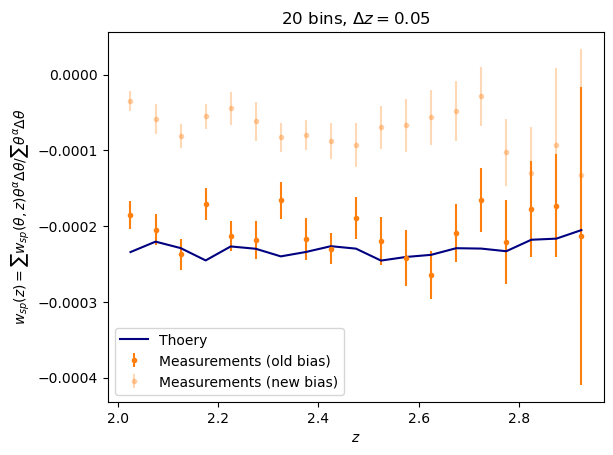

In [337]:
# plot:
plt.errorbar(Z_20, wsp_measure_old[:,0], yerr=wsp_measure_old[:,1], fmt='.', label='Measurements (old bias)',color='C1')
plt.errorbar(Z_20, wsp_measure_new[:,0], yerr=wsp_measure_new[:,1], fmt='.', label='Measurements (new bias)',color='C1', alpha=0.3)
plt.plot(Z_20[:-1], Wsp_theta1030_dz05_rsd_mean[:-1], label="Thoery",color='navy')
#plt.ylim([0,0.0015])
plt.title("20 bins, $\\Delta z = 0.05$")
plt.xlabel("$z$")
plt.ylabel("$w_{sp}(z) = \\sum w_{sp}(\\theta, z)\\theta^{\\alpha}  \\Delta \\theta/\\sum \\theta^{\\alpha} \\Delta \\theta$")
plt.legend()

# n(z) (old bias, new theta scaling)

In [321]:
# compute theory here:
nz_est_theory = np.zeros(20)
Dz = 0.05
nz_est_theory[:-1] = -Wsp_theta1030_dz05_rsd_mean[:-1]/np.sqrt(Wss_theta1030_dz05_rsd_mean[:-1]*Wb2_10_30_dz05_rsd)/Dz

In [338]:
# load data:
root = "/pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-20bin/"
nz_measure_old = np.loadtxt(root + "nz_estimate-raw-wpp-thetacomb-alpha-0-theta-min-10-max-30.dat")

root = "/pscratch/sd/q/qhang/desi-lya/results-newbias/run-0/yaw-20bin/"
nz_measure_new = np.loadtxt(root + "nz_estimate-raw-wpp-thetacomb-alpha-0-theta-min-10-max-30.dat")

Text(0.5, 1.0, 'Double integ. + RSD, $\\theta = [10,30]$ arcmin w. $\\alpha=0$, $\\Delta z = 0.05$')

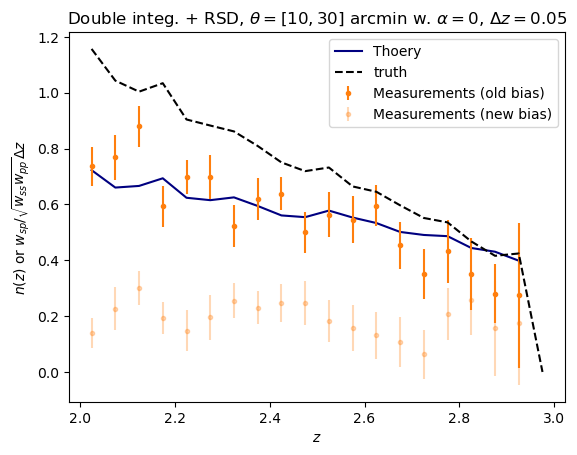

In [339]:
plt.plot(Z_20[:-1], nz_est_theory[:-1] , label="Thoery",color='navy')
plt.errorbar(nz_measure_old[:,0],nz_measure_old[:,1],  yerr=nz_measure_old[:,2], fmt='.', label='Measurements (old bias)',color='C1')
plt.errorbar(nz_measure_new[:,0],nz_measure_new[:,1],  yerr=nz_measure_new[:,2], fmt='.', label='Measurements (new bias)',color='C1',
            alpha=0.3)
plt.plot(zbin_cen, nz_gal_law(zbin_cen), label="truth", color='k', ls='--')
plt.legend()

plt.xlabel("$z$")
plt.ylabel("$n(z)$ or $w_{sp}/\\sqrt{w_{ss}w_{pp}}\\Delta z$")
plt.title("Double integ. + RSD, $\\theta = [10,30]$ arcmin w. $\\alpha=0$, $\\Delta z = 0.05$")

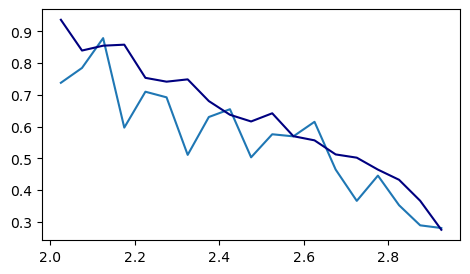

In [402]:
data_check = wsp_measure_old[:,0]/np.sqrt(w_combalpha_newbias[1,:]* wss_measure[:,0])/Dz

plt.plot(Z_20, -data_check)

nz_est_theory2=np.zeros(20)
nz_est_theory2[:-1] = -Wsp_theta1030_dz05_rsd_mean[:-1]/np.sqrt(wss_measure[:,0][:-1]*Wb2_10_30_dz05_rsd)/Dz

plt.plot(Z_20[:-1], nz_est_theory2[:-1] , label="Thoery",color='navy')
#plt.plot(Z_20[:-1], Wss_theta1030_dz05_rsd_mean[:-1], label="Thoery",color='navy')
#plt.plot(Z_05, Wb2_10_30_dz05_rsd
##plt.plot(Z_20[:-1], Wsp_theta1030_dz05_rsd_mean[:-1], label="Thoery",color='navy')

# let's try to fit $w_{sp}$ as a function of theta, and redshift 

We do this for 20 z-bins and 10 z-bins.

The goal is the following:
- Fit linear and non-linear theory to the data to see when it breaks (note: galaxy mock bias needs to be updated)
- Compute SNR as a function of theta
- Determine angular scales and angular weighting

In [25]:
# load the measurements below:
Nbins=20
theta_min=1
theta_max=50
ntheta=15
root = f"/pscratch/sd/q/qhang/desi-lya/results/run-0/yaw-{Nbins}bin/"
wsp_thetasplit = np.loadtxt(root + f"w_sp-raw-thetasplit-min-{theta_min}-max-{theta_max}.txt")

In [26]:
wsp_thetasplit.shape

(64, 300)

In [30]:
wsp_thetasplit

array([[-9.54842340e-04, -1.06598125e-03, -1.04048423e-03, ...,
        -4.37393516e-05,  6.74681333e-05,             nan],
       [-9.67717150e-04, -1.07822381e-03, -1.06293021e-03, ...,
        -4.28110031e-05,  6.89109278e-05,             nan],
       [-9.63381044e-04, -1.06251449e-03, -1.04683332e-03, ...,
        -4.25405239e-05,  1.05812700e-04,             nan],
       ...,
       [-9.65037353e-04, -1.07101151e-03, -1.06105692e-03, ...,
        -2.69312223e-05,  8.13852736e-05,             nan],
       [-9.69047788e-04, -1.07014165e-03, -1.06435273e-03, ...,
        -3.68384506e-05,  5.89254634e-05,             nan],
       [-9.70502787e-04, -1.06116683e-03, -1.04563083e-03, ...,
        -4.71079954e-05,  3.97029762e-05,             nan]],
      shape=(64, 300))

In [48]:
# let'sc compute mean and std for these:
wsp_theta_split_mean = np.mean(wsp_thetasplit,axis=0)
wsp_theta_split_mean = wsp_theta_split_mean.reshape((ntheta,Nbins))
wsp_theta_split_std = np.std(wsp_thetasplit,axis=0)*np.sqrt(64)
wsp_theta_split_std = wsp_theta_split_std.reshape((ntheta,Nbins))
theta_1_50_binedge = np.logspace(np.log10(theta_min),np.log10(theta_max),ntheta+1)
theta_1_50_bincen = (theta_1_50_binedge[1:] + theta_1_50_binedge[:-1])/2.
redshift_binedges = np.linspace(2,3,Nbins+1)
redshift_bincen = (redshift_binedges[1:] + redshift_binedges[:-1])/2.

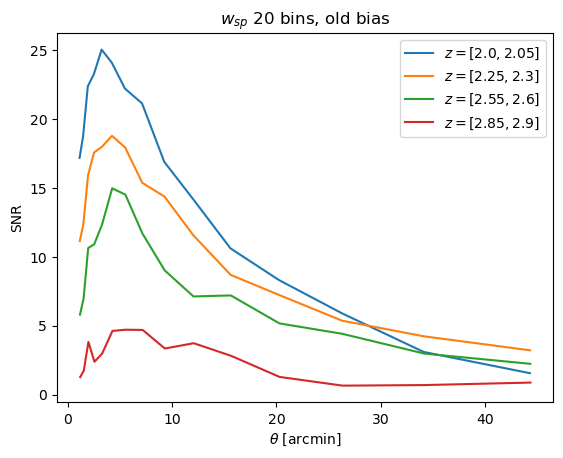

In [65]:
# plot SNR for each measurement below:
plt.title("$w_{sp}$ 20 bins, old bias")
plt.xlabel("$\\theta$ [arcmin]")
# pick some redshifts to inspect:
for tick ,ii in enumerate([0,5,11,17]):
    plt.plot(theta_1_50_bincen + tick*0.02, abs(wsp_theta_split_mean[:,ii]/wsp_theta_split_std[:,ii]),
                label=f"$z=[{redshift_binedges[ii]},{redshift_binedges[ii+1]}]$")
plt.ylabel("SNR")
plt.legend()

In [55]:
# now let's compute the theory w_sp with RSD, with non-linear PS:
# let's use the existing setup - later, we want to speed up the process:

Dz=0.05 # 20 bins
redshift_use = redshift_bincen[[0,5,11,17]] # let's do a few redshifts

nz_law = nz_gal_law
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya_fixed # this is for lya
bias_law1 = bias_law_gal
bias_law2 = bias_law_lya

Wsp_theta150_dz05_rsd=np.zeros((ntheta,4))

for itheta in range(ntheta):
    print(itheta)
    for ii, zmean in enumerate(redshift_use):
        theta = theta_1_50_bincen[itheta]
        Wsp_theta150_dz05_rsd[itheta, ii] = wnotLimber_rsd_theta_cross(zmean, Dz, nz_law, theta, beta_law1, 
                                                   beta_law2=beta_law2, bias_law1=bias_law1, 
                                                       bias_law2=bias_law2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


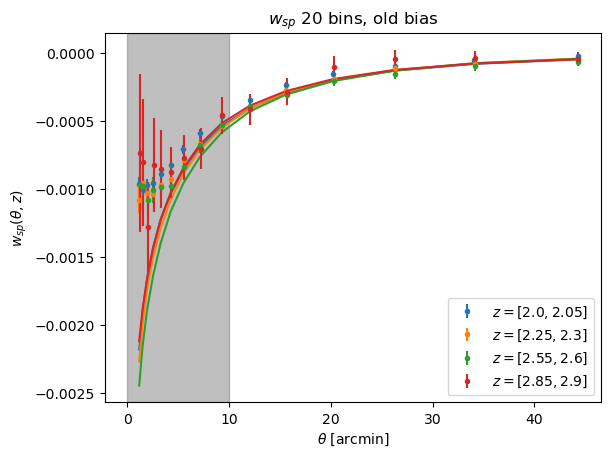

In [67]:
# pick some redshifts to inspect:
for tick ,ii in enumerate([0,5,11,17]):
    plt.errorbar(theta_1_50_bincen + tick*0.02, wsp_theta_split_mean[:,ii], yerr=wsp_theta_split_std[:,ii], fmt='.',
                label=f"$z=[{redshift_binedges[ii]},{redshift_binedges[ii+1]}]$")
    plt.plot(theta_1_50_bincen, Wsp_theta150_dz05_rsd[:,tick], color=f'C{tick}')
#plt.xscale("log")
plt.title("$w_{sp}$ 20 bins, old bias")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}(\\theta, z)$")
plt.legend()
plt.axvspan(0, 10, alpha=0.5, color='grey')

Lowest bin has a constant amplitude offset, of ~0.8


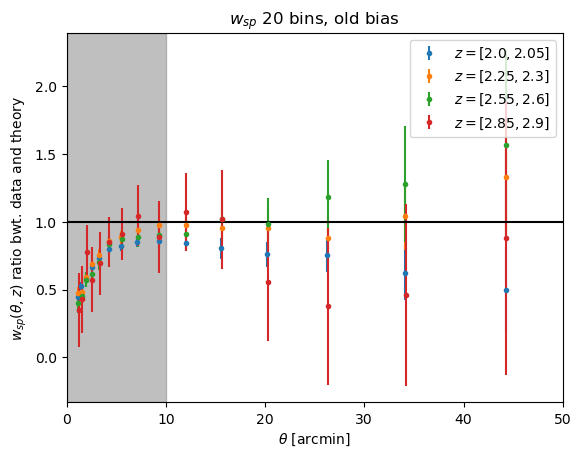

In [78]:
# pick some redshifts to inspect: data over theory:
for tick ,ii in enumerate([0,5,11,17]):
    data = wsp_theta_split_mean[:,ii]
    error = wsp_theta_split_std[:,ii]
    theory=Wsp_theta150_dz05_rsd[:,tick]
    plt.errorbar(theta_1_50_bincen + tick*0.02, data/theory, yerr=abs(error/theory), fmt='.',
                label=f"$z=[{redshift_binedges[ii]},{redshift_binedges[ii+1]}]$")
#plt.xscale("log")
plt.title("$w_{sp}$ 20 bins, old bias")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}(\\theta, z)$ ratio bwt. data and theory")
plt.legend()
plt.axvspan(0, 10, alpha=0.5, color='grey')
plt.axhline(1,color='k')
plt.xlim([0,50])
print("Lowest bin has a constant amplitude offset, of ~0.8")

In [88]:
# now, also try with linear theory:
# to do this, we first need to get xi(r) linear and save it:
# let's use andreu's method to get xi(r) linear as CCL default is non-linear...

# matter linear power at a pivot redshift (smoothed with a tiny Gaussian for stability)
k_Mpc=np.logspace(-4, 2, 2**12)
z_p=3
# smooth power with Gaussian for stability
sig_Mpc=0.2
P_L_Mpc=ccl.power.linear_matter_power(cosmo, k_Mpc, a=1/(1+z_p)) * np.exp(-(k_Mpc*sig_Mpc)**2)

In [90]:
# save this
np.savetxt("P_L_Mpc.txt", P_L_Mpc)

In [91]:
# ratio of the linear growth factor at z and at z_p
def D_z_p(z,z_p):
    return ccl.growth_factor(cosmo,1/(1+z))/ccl.growth_factor(cosmo,1/(1+z_p))

# logarithmic growth rate at a given redshift
def f_z(z):
    return ccl.growth_rate(cosmo,1/(1+z))

In [94]:
# now load the linear xi 0, 2, 4 here, construct interpolator as a func of r, z:
fin = np.loadtxt("xi_L_0.txt")
r_Mpc, xi_L_0 = fin[:,0], fin[:,1]

fin = np.loadtxt("xi_L_2.txt")
xi_L_2 = fin[:,1]

fin = np.loadtxt("xi_L_4.txt")
xi_L_4 = fin[:,1]

xi_L_0 = interpolate.interp1d(r_Mpc, xi_L_0)
xi_L_2 = interpolate.interp1d(r_Mpc, xi_L_2)
xi_L_4 = interpolate.interp1d(r_Mpc, xi_L_4)

In [95]:
# linear rsd xi:
def xi_rsd_lin(R,z,mu,beta,beta2=None,z_p=3):
    """Note beta is also a function of z, we will compute it later
    """
    if beta2 == None:
        beta2 = np.copy(beta)
        
    xi_0 = (1 + 1/3.*(beta + beta2) + 1/5.*beta*beta2)*xi_L_0(R)
    xi_2 = (2/3.*(beta + beta2) + 4/7.*beta*beta2)*xi_L_2(R)
    xi_4 = 8/35.*beta*beta2*xi_L_4(R)

    P_0 = 1
    P_2 = 1/2.*(3*mu**2-1)
    P_4 = 1/8.*(35*mu**4 - 30*mu**2 + 3)

    return (xi_0*P_0 + xi_2*P_2 + xi_4*P_4)*D_z_p(z,z_p)**2

In [97]:
def wnotLimber_rsd_theta_cross_lin(zmean, Delta_z, nz_law, theta_arcmin, beta_law1, beta_law2=None,
                              bias_law1=None, bias_law2=None): # Here we assume tophat n(z), much faster than the following function
    """
    Because of the relatively broad kernel, we take into account all 
    functions varying with redshift in the integrand. This includes both 
    beta and bias.
    This is for linear power spectrum!!
    """
    zmin2=-Delta_z/2
    zmax2=+Delta_z/2

    zmin1=1.8-zmean
    zmax1=3.0-zmean

    theta_deg=theta_arcmin/60
    theta_rad=theta_deg/360*(2*math.pi)
    rp=theta_rad*ra_cosmo(zmean) #from Mpc to rad, to deg
    
    def integrate_z1(z1):
        # outer integral over the photometric n(z)
        def integrate_z2(z2):
            # inner integral over the top hat
            r=r_3d_rp(rp,zmean+z1,zmean+z2) # what is the r3d given our redshifts
            mu = mu_rsd(zmean+z1,zmean+z2,r)

            if r<0.11:# not too small...
                return 0
            if r>300:# not too large...
                return 0
            old_output = xi_rsd_lin(r,zmean+z1,mu,beta_law1(zmean+z1, bias_law1),beta2=beta_law2(zmean+z2))
            return old_output*nz_law(zmean+z1)*bias_law1(zmean+z1)*bias_law2(zmean+z2)
        return 1/Delta_z*quad(integrate_z2, zmin2, zmax2, epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]
    return quad(integrate_z1,zmin1,zmax1,epsrel=10**(-3),epsabs=10**(-5),limit=100)[0]

In [98]:
# now let's see if this works!

Dz=0.05 # 20 bins
redshift_use = redshift_bincen[[0,5,11,17]] # let's do a few redshifts

nz_law = nz_gal_law
beta_law1 = beta_law_gal #this is for galaxy
beta_law2 = beta_law_lya_fixed # this is for lya
bias_law1 = bias_law_gal
bias_law2 = bias_law_lya

Wsp_theta150_dz05_rsd_lin=np.zeros((ntheta,4))

for itheta in range(ntheta):
    print(itheta)
    for ii, zmean in enumerate(redshift_use):
        theta = theta_1_50_bincen[itheta]
        Wsp_theta150_dz05_rsd_lin[itheta, ii] = wnotLimber_rsd_theta_cross_lin(zmean, Dz, nz_law, theta, beta_law1, 
                                                   beta_law2=beta_law2, bias_law1=bias_law1, 
                                                       bias_law2=bias_law2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


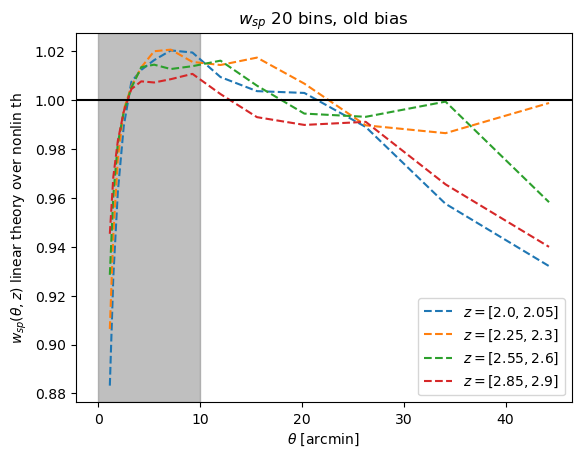

In [105]:
# pick some redshifts to inspect:
for tick ,ii in enumerate([0,5,11,17]):
    #plt.plot(theta_1_50_bincen, , color=f'C{tick}',label=label1)
    plt.plot(theta_1_50_bincen, Wsp_theta150_dz05_rsd_lin[:,tick]/Wsp_theta150_dz05_rsd[:,tick], 
             color=f'C{tick}',ls='--',label=f"$z=[{redshift_binedges[ii]},{redshift_binedges[ii+1]}]$")
#plt.xscale("log")
plt.title("$w_{sp}$ 20 bins, old bias")
plt.xlabel("$\\theta$ [arcmin]")
plt.ylabel("$w_{sp}(\\theta, z)$ linear theory over nonlin th")
plt.legend()
plt.axhline(1,color='k')
plt.axvspan(0, 10, alpha=0.5, color='grey')